In [10]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# <center>Network Analysis of Financial Markets<center>

# 1. Abstract 
In this project we have analysed the dynamics of the Financial Markets through Network Analysis.We have built networks of the equities that are part of the  S and P 500 index over a range Time Periods between 2007 and 2017 based on Winner Take All and the Minimum Spanning Tree method .Both these methods utilise the correlation coefficient computed between the attributes of these stocks such as Price,Volume,Returns etc . Community detection techniques were then applied to the constructed networks. The resulting communities were compared for consistency with the identified market sections using Standard Industrial Classification code.We also studied the evolution of the network and the  communities over the study period and found interesting behaviors. We have compared our results from both the methods for each of our analysis.We created a GEXF file for this dynamic network and visuvalised the same  in Gephi a open source network visuvalisation software.The visualization results offer a very intuitive
way to look at the overall correlation structure of different the equities in the S and P 500 and evolution of these networks over a period of time .

# 2. Introduction

Network analysis of Equities is a extensively researched topic and in section 3 we have detailed current literature which was utilised as part of this project.In all the current studies the focus has been on studying the properties of the market in a stationary view  for a fixed time period.By leveraging the techniques noted in these current literature we have as part of this study built multiple networks of the stocks in the S and P 500 index for mutiple non overlapping windows of Time Period (T) between 2007 and 2017 and studied how the network evolves and how the communities in the network behave with the changing dynamics of the market.

Below are key Objectives of the project.For each of these items we have compared the results we got for for the networks built based on both these methods. 

    1. Build network for the stocks in  S and P 500 index based on the correlations between Prices/Volume for Multiple Time Periods using Winner Take All method and Minimum Spanning Tree Method
    2. Analyse the topology of the networks in multiple time periods.Does the network of stocks exhibit scale free properties at each of the time period?
    3. Detect communities in these networks and find out if the stocks actually trade in groups based on the SIC(Standard Industry Classification) Code.
    4. Studied the evolution of these communities 
    5. Find important stocks and sectors they belong to based on the Network Properties at Different time periods.
    6. Visuvalize the network and also the dynamic evolution of network by building dynamic graphs using Gephi

# 3. Literature Review

Current Studies about network analysis for stock market can be classified
into below categories : 

   (1) Applying network analysis techniques for different markets and analyze the topological characteristics of each market 
             [Statistical Analysis of Financial Markets][1],
             [Hierarchical structure in financial markets][2]
       
   (2) Propose different correlation metric analysis among various stock markets to suggest different definitions of edges between stocks and study the impact on the network using different edge definitions
             [Network analysis of a financial market based on genuine correlation and threshold method][3],
             [Network of Equities in Financial Markets][4],
             [A network perspective of the stock market][5]

[1]:https://www.researchgate.net/publication/222564938_Statistical_analysis_of_financial_networks
[2]:https://www.researchgate.net/publication/253665724_Hierarchical_structure_in_financial_market
[3]:https://www.researchgate.net/publication/228454212_Network_analysis_of_a_financial_market_based_on_genuine_correlation_and_threshold_method
[4]:https://arxiv.org/pdf/cond-mat/0401300.pdf
[5]:https://www.researchgate.net/publication/222825530_A_network_perspective_of_the_stock_market
[6]:https://www.researchgate.net/publication/5499066_Detrended_Cross-Correlation_Analysis_A_New_Method_for_Analyzing_Two_Nonstationary_Time_Series
[7]:https://www.researchgate.net/publication/44884990_Time-lag_cross-correlations_in_collective_phenomena

## 3.1. Edge Definition

Approach to construct the edges of stock market network is
not unique. In the current literature, multiple measures were
investigated to construct the edges between nodes namely [Zero-lag correlation][2],[Detrended covariance][6],[Time-lag correlations of prices changes over a certain period of time][7] 



## 3.2. Network Properties
Studies have covered both emerging and mature markets. Authors
claim that understanding the topological properties can
help to understand correlation patterns among stocks, thus providing
guidance for risk management. Topological properties
often of interest include degree distribution, clustering and component
structure. In this subcategory study, usually only one
correlation measure is proposed to establish the connections
between nodes. In the introduction session of [Statistical Analysis of Financial Markets][1], the author
covered a wide range of previous studies in this category

# 4. Build Network
## 4.1 Data Collection

We collected the prices for the stocks that trade in both NASDAQ and the NYSE stock exchange from [Eod Data][8] . The data consisted of Opening , Closing prices , Volume information for each trading day for the period of 2007 to 2017.From this data we filtered and selected only the prices that are a part of S and P 500 . We chose the [S and P 500][9] since the index had a well balanced portfolio of stocks from different industry segments .

[8]:http://eoddata.com/
[9]:https://en.wikipedia.org/wiki/S%26P_500_Index

In [6]:
## Read S and P 500 list
import pandas as pd
import numpy as np
dfsp500 = pd.read_csv('../data/SANDP500.csv')
companies=dfsp500['Symbol'].tolist()
companies=np.random.choice(companies, size=500, replace=False)

In [7]:
import glob
import os
path = r'../data/NASDAQ'                     
all_files = glob.glob(os.path.join(path, "*.txt"))     
df_from_each_file = (pd.read_csv(f) for f in all_files)
concatenated_df_NAS   = pd.concat(df_from_each_file, ignore_index=True)
concatenated_df_NAS=concatenated_df_NAS[concatenated_df_NAS['<ticker>'].isin(companies)]

path = r'../data/NYSE'                     
all_files = glob.glob(os.path.join(path, "*.txt"))     
df_from_each_file = (pd.read_csv(f) for f in all_files)
concatenated_df_NYS   = pd.concat(df_from_each_file, ignore_index=True)
concatenated_df_NYS=concatenated_df_NYS[concatenated_df_NYS['<ticker>'].isin(companies)]

concatenated_df = pd.concat([concatenated_df_NAS,concatenated_df_NYS])

In [8]:
col_p = 'close'
concatenated_df.columns = ['ticker','date','open','high','low','close','vol']
concatenated_df=concatenated_df[concatenated_df['ticker'].isin(companies)]
concatenated_df=concatenated_df.merge(dfsp500,left_on='ticker',right_on='Symbol')
concatenated_df['ticker'] = concatenated_df['ticker']
df_price = concatenated_df[['ticker','date',col_p]]
df_price=df_price.drop_duplicates( keep='last')
df_price['date'] = pd.to_datetime(df_price['date'], format='%Y%m%d', errors='ignore')
df_price.set_index(['date','ticker'],inplace=True)
df_price=df_price.unstack()[col_p]
df_price.reset_index(inplace=True)
df_price.fillna(method='bfill',inplace=True)
df_price.fillna(method='ffill',inplace=True)

/var/folders/ql/zddshrpn57g78r770hdqrm6r0000gn/T/ipykernel_87737/3903846218.py:8: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df_price['date'] = pd.to_datetime(df_price['date'], format='%Y%m%d', errors='ignore')
/var/folders/ql/zddshrpn57g78r770hdqrm6r0000gn/T/ipykernel_87737/3903846218.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_price.fillna(method='bfill',inplace=True)
/var/folders/ql/zddshrpn57g78r770hdqrm6r0000gn/T/ipykernel_87737/3903846218.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_price.fillna(method='ffill',inplace=True)


## 4.2 Detrend data - Compute log returns

Of the methods in current literature number we choose [Time-lag correlations of prices changes over a certain period of time][7] .One of the keys challenges in computing the correlation on stock prices is that the values are moving time series and have inherent trends which can lead to spurious correlations if the data is not properly normalised.

If we think about a time series of prices, you could write it out as 

    [P0,P1,P2,...,PN], or [P0,P0+R1,P0+R1+R2,...,P0+R1+...+RN], where Ri = Pi-P(i-1). 

Written this way we can see that the first return R1, contributes to every entry in the series, whereas the last only contributes to one. This gives the early values in the correlation of prices more weight than they should have.

So for computing the correlation we take the difference between the prices for each day giving us the returns for each .We computed the log returns between two days since it has a key benefit of being additive over multiple time periods .

Though log returns can be computed over multiple time periods of 7 , 30 , 60 , 100 days for the sake of simplicity we kept the return window to 1 day.

[7]:https://www.researchgate.net/publication/44884990_Time-lag_cross-correlations_in_collective_phenomena

In [10]:
import scipy.signal
t = 1
for key in df_price.columns:
    if key not in companies:
        continue
    try:
        df_price[key] = np.log(df_price[key]) - np.log(df_price[key].shift(t))
    except:
        print (key)
df_price.set_index('date',inplace=True)

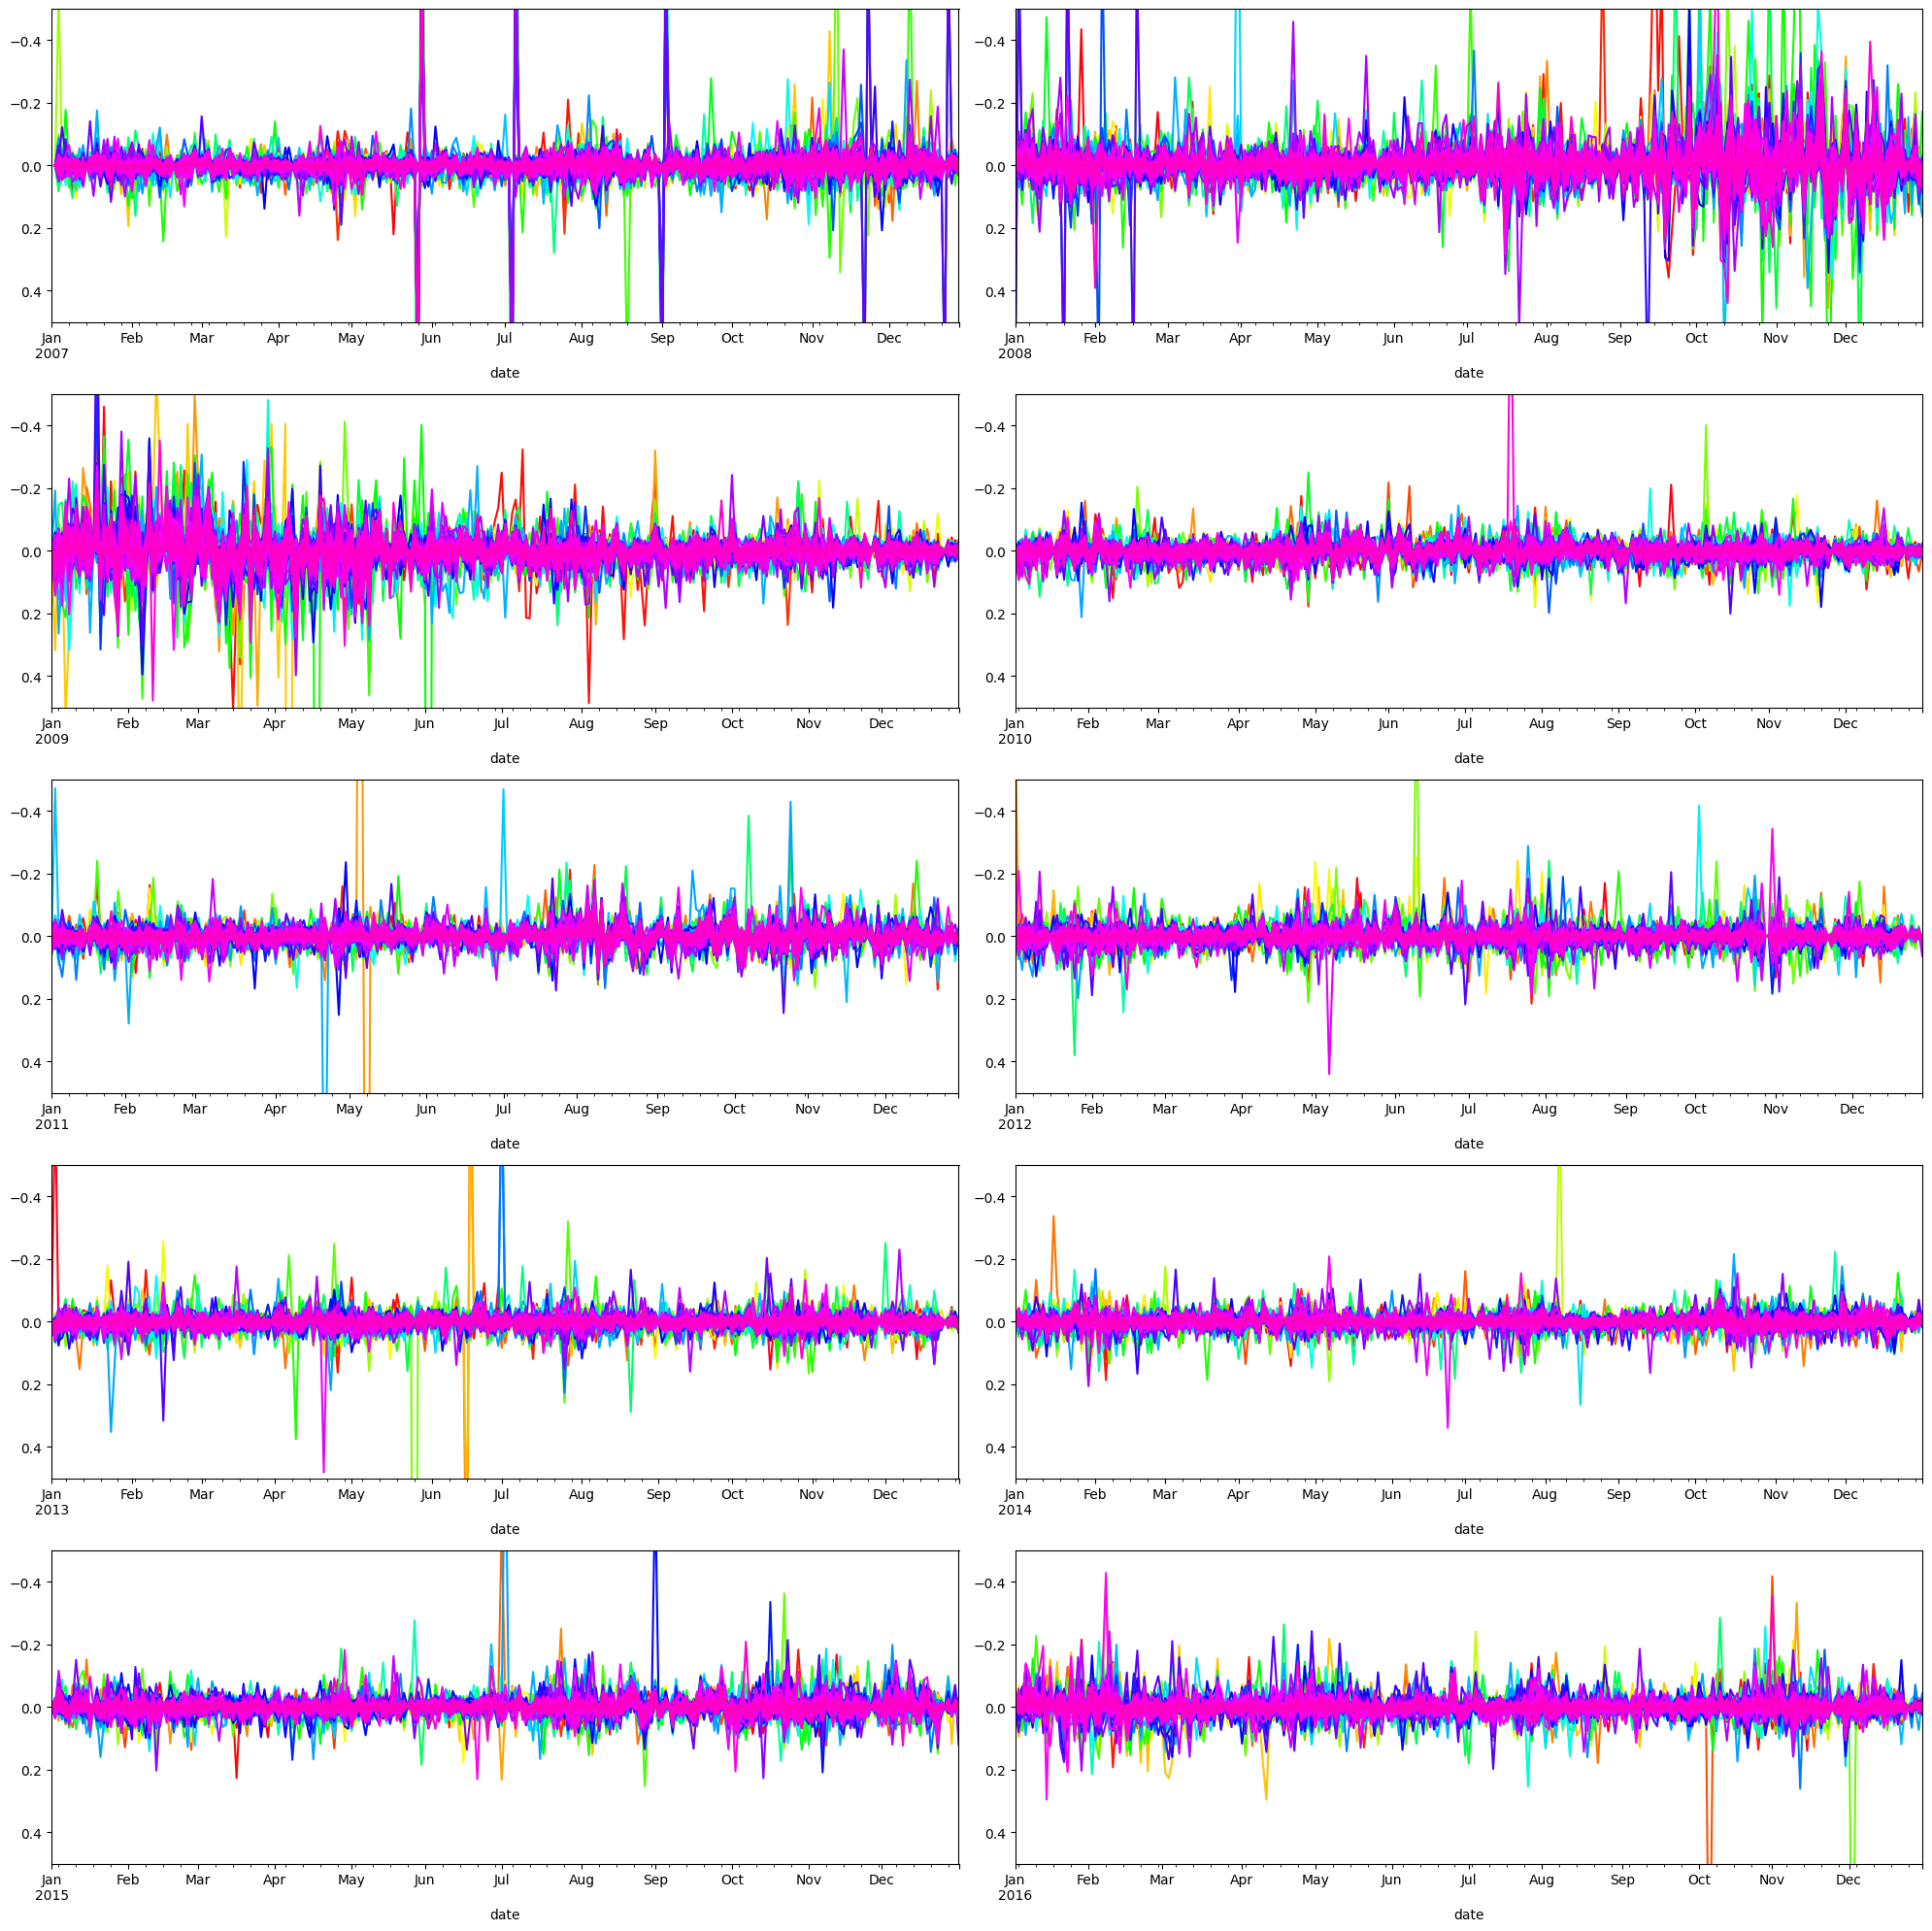

In [12]:
## A quick visualization: detrended data
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn
NUM_COLORS = len(companies)
cm = plt.get_cmap('gist_rainbow')
colors = [cm(i/NUM_COLORS) for i in range(NUM_COLORS)]
rn.seed = len(companies)  # for choosing random colors
fig, ax = plt.subplots(nrows=5,ncols=2,figsize=(20, 20))
y=2007
for row in ax:
    for col in row:
        yfs = str(y) + '0101'
        yfe = str(y) + '1231'
        n = 0
        col.set_ylim([0.5, -0.5])
        for i in df_price.columns:
            df_price.loc[yfs:yfe][i].plot(ax=col,color=colors[n])
            n = n + 1
        y = y + 1
plt.tight_layout()
plt.show()

## 4.3 Compute Correlation matrix for multiple windows

Next we computed the pearson correlation between the log returns.The data is divided into  windows of width (T)  in order to uncover dynamic characteristics of the networks. The window width  corresponds to the number of daily returns included in the computation of the correlation between Stocks. The method of time windows division to construct asset graphs can be found in the literature [Asset trees and asset graphs in financial markets][10]

To determine the ideal length of the window we computed the mean correlation for window values of 21,42,63,84 and 105 and plotted the variations in the correlation.As seen in the plot the window of 63 captures the fluctuations of the market well.Values less than this are too noisy and higher than this we lose the sensitivity in the changes in the market .Also from a market perspective 63 days ideally falls into the Quarterly reporting cycle of these companies so we felt it would be appropriate choice

The correlation matrix is then computed based on this window length of 63 by dividing the period between 2007 and 2017 into multiple windows.

[10]:https://arxiv.org/abs/cond-mat/0303579

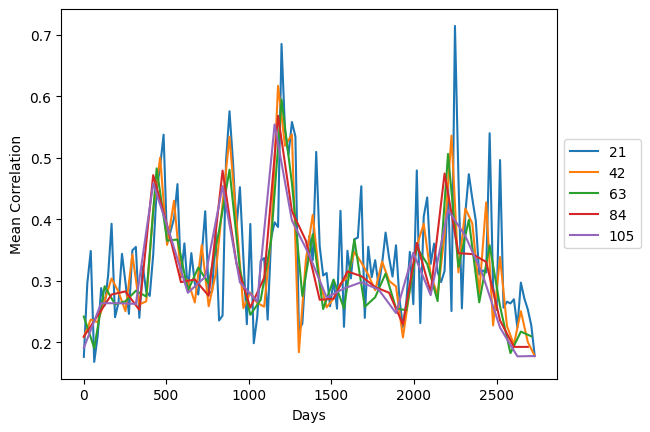

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
corr_dict = {}
T = 1
for w in range(21,126,21):
    x = []
    y = []
    W = w
    for i in range(t,len(df_price),W):
            dkey = i
            corr_dict[dkey]=df_price.iloc[i:(i+W)].corr(method='pearson')
            corr_dict[dkey].fillna(0,inplace=True)
            x.append(dkey)
            y.append(np.mean([abs(j) for j in corr_dict[dkey].values.flatten().tolist()]))
    plt.plot(x,y)
    plt.xlabel('Days')
    plt.ylabel('Mean Correlation')
    plt.legend(list(range(21,126,21)), loc='center left', bbox_to_anchor=(1, 0.5),ncol=1)
plt.show()
W = 63
corr_dict = {}
for i in range(t,len(df_price),W):
      dkey = i
      corr_dict[dkey]=df_price.iloc[i:(i+W)].corr(method='pearson')
      corr_dict[dkey].fillna(0,inplace=True)

# 4.4 Build network - (Winner take all method)
Literature [A network perspective of the stock market][5] details the winner take all method where we build a network based on the correlation matrix if the value of the Correlation index is greater than a threshold.

What is the ideal value of threshold ?.Since one the key objectives of the study is to find if the stocks behave in groups we wanted to select a threshold which maximises the modularity .However we were also consious not overfit the data in which case we might loose some of the underlying dynamics at work in the market.

In the next step we built the network based on different thresholds ranging from 0.6 to 0.99 for  the windows identified .We then picked the value of the threshold from the values where the modularity is maximum.On analysis of this result we noted that most networks tended to have a high modularity for threshold value between 0.75 and 0.85 .There were certains windows where the threshold for the best modularity was seen to be greater than 0.9 however at this threshold the number edges was very less so in such cases we set the threshold to 0.8 and built the network.We treated both positive and negative correlations the same and looked at the absolute value.

[5]:https://www.researchgate.net/publication/222825530_A_network_perspective_of_the_stock_market

In [16]:
import networkx as nx
import community.community_louvain as community_louvain
def get_modularity(y,threshold):
    df_price_corr = corr_dict[y]
    elist = []
    outdict=df_price_corr.to_dict()
    for i in outdict.keys():
        for j in outdict[i].keys():    
            if abs(outdict[i][j]) > threshold :
                if i == j :
                    continue
                if i < j:
                    elist.append([i,j,dict(weight=abs(outdict[i][j]),start=y,end=y+W)])
                    #elist.append([i,j,dict(start=y,end=y+1)])
                else:
                    None
    #print (len(elist))
    G=nx.Graph()
    G.add_edges_from(elist)
    #print (nx.info(G))
    partition = community_louvain.best_partition(G)
    try:
        m = community_louvain.modularity(partition, G)
    except:
        m = 0 
    return m
# This will be our list of fractions to run the simulation over
fractions = np.linspace(0.6, 0.99, 20)
M_list = {}
for y in corr_dict.keys():
    M_list[y] = [ get_modularity(y, frac)  for frac in fractions ]

The below is the plot between the threshold value and the computed markdown in the various windows

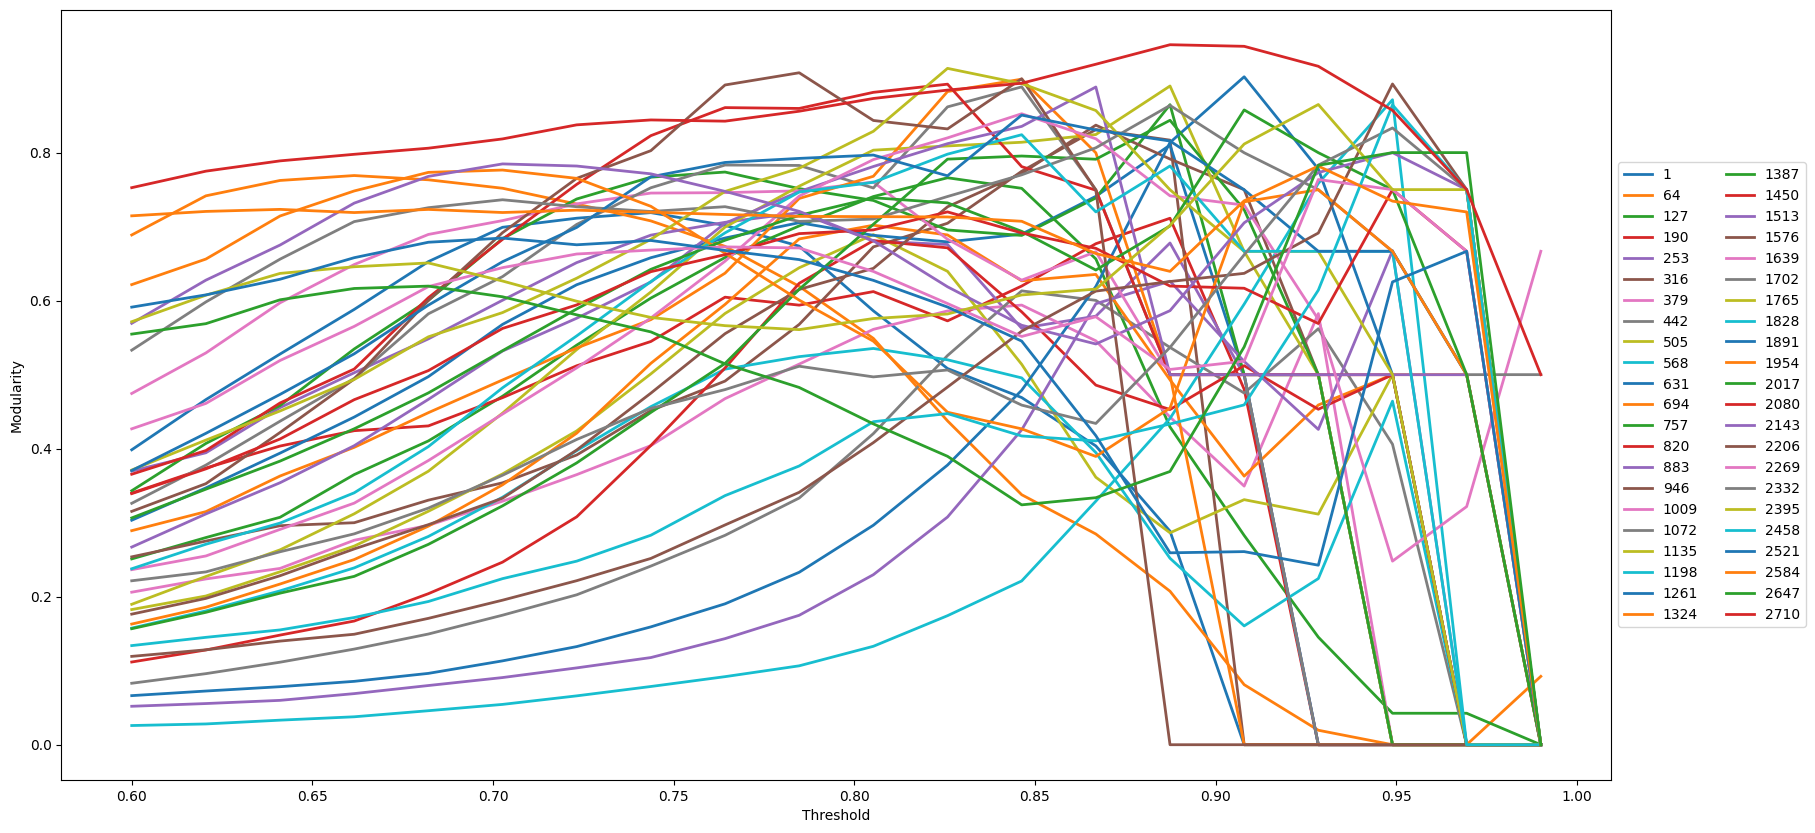

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,10))
for y in corr_dict.keys():
    plt.plot(fractions, M_list[y], lw=2)
plt.legend(list(M_list.keys()), loc='center left', bbox_to_anchor=(1, 0.5),ncol=2)
plt.xlabel('Threshold')
plt.ylabel('Modularity')
plt.show()

In [18]:
# Pick value of threshold for each Window (T)
T_val = {}
for y in M_list.keys():
    val, idx = max((val, idx) for (idx, val) in enumerate(M_list[y]))
    if fractions[idx] > 0.8:
        T_val[y] = 0.8
    else:
        T_val[y] = fractions[idx]
    #print (str(y) + ":" + str(T_val[y]))

In [19]:
# Create Edge List
elist_dict={}
for y in corr_dict.keys():
    df_price_corr = corr_dict[y]
    threshold = T_val[y]
    elist = []
    outdict=df_price_corr.to_dict()
    for i in outdict.keys():
        for j in outdict[i].keys():
            if abs(outdict[i][j]) > threshold :
                if i == j :
                    continue
                if i < j:
                    elist.append([i,j,dict(weight=1,start=y,end=y+W-1)])
                else:
                    None
    elist_dict[y] = elist

In [22]:
import networkx as nx
import community.community_louvain as community_louvain

G_dict = {}
for y in elist_dict.keys():
    G = nx.Graph()
    elist = elist_dict[y]
    G.add_edges_from(elist)
    
    values = dfsp500.set_index('Symbol').to_dict(orient='dict')['Sector']
    for node, value in values.items():
        try:
            G.nodes[node]['Sector'] = value  # Updated to G.nodes[node]
        except:
            None
    
    partition = community_louvain.best_partition(G)
    
    deg_cent = dict((k, float(v)) for k, v in nx.degree_centrality(G).items())
    degree = dict((k, float(v)) for k, v in G.degree())  # Corrected this line
    
    # katz_cent=nx.katz_centrality(G)
    # eigen_cent= dict((k,float(v)) for k,v in nx.eigenvector_centrality(G).items()) 
    close_cent = dict((k, float(v)) for k, v in nx.closeness_centrality(G).items())
    betw_cent = dict((k, float(v)) for k, v in nx.betweenness_centrality(G).items())
    
    nx.set_node_attributes(G, partition, "community")
    nx.set_node_attributes(G, deg_cent, "degreecent")
    nx.set_node_attributes(G, degree, "degree")
    # nx.set_node_attributes(G, katz_cent, "katz")
    # nx.set_node_attributes(G, eigen_cent, "eigenvector")
    nx.set_node_attributes(G, close_cent, "closeness")
    nx.set_node_attributes(G, betw_cent, "betweenness")
    nx.set_node_attributes(G, y, 'start')
    nx.set_node_attributes(G, y+W-1, 'end')
    
    # G.remove_nodes_from(nx.isolates(G)) 
    # T = nx.minimum_spanning_tree(G)
    T = G
    G_dict[y] = T

In [27]:
# Collect the node-level attributes for the nodes for all the windows
df_list = []
for k in G_dict.keys():
    G = G_dict[k]
    a = dict(G.nodes(data=True))  # Use G.nodes(data=True) to get node attributes as a dictionary
    df_list.append(pd.DataFrame(a).T.reset_index())

attrib_df = pd.concat(df_list)
attrib_df.fillna(0, inplace=True)

# Ensure both 'index' and 'Symbol' columns are of the same type (string)
attrib_df['index'] = attrib_df['index'].astype(str)
dfsp500['Symbol'] = dfsp500['Symbol'].astype(str)

attrib_df1 = attrib_df.merge(dfsp500, left_on='index', right_on='Symbol')
attrib_df = attrib_df1[['index', 'Sector_x', 'betweenness', 'closeness', 'community', 'degree', 'degreecent', 'start', 'Name']]
attrib_df.columns = ['ticker', 'Sector', 'Betweeness', 'Closeness', 'Community', 'Degree', 'DegreeCent', 'start', 'Name']

In [29]:
# Collect the graph-level attributes for all the windows
from scipy.stats import linregress
G_val_dict = {}
for Y in G_dict.keys():
    G_val = {}
    G = G_dict[Y]
    G_val['nodes'] = int(nx.number_of_nodes(G))
    G_val['edges'] = int(nx.number_of_edges(G))
    G_val['AvgClustering'] = nx.average_clustering(G)
    
    try:
        G_val['AvgShortestPathLength'] = nx.average_shortest_path_length(G)
    except:
        G_val['AvgShortestPathLength'] = 99999
    
    try:
        G_val['Diameter'] = nx.diameter(G)
    except:
        G_val['Diameter'] = 99999
    
    degs = {}
    for n in G.nodes():
        deg = G.degree(n)
        if deg not in degs.keys():
            degs[deg] = 0
        degs[deg] += 1
    
    items = sorted(degs.items())
    x = [k for (k, v) in items]
    y = [v for (k, v) in items]
    xlog = np.array([np.log(k) for (k, v) in items])
    ylog = np.array([np.log(v) for (k, v) in items])
    
    slope, intercept, rvalue, pvalue, stderr = linregress(xlog, ylog)
    G_val['Slope'] = slope
    
    G_val['No of Communities'] = attrib_df.groupby(by=['start'])['Community'].nunique().loc[Y]
    G_val_dict[Y] = G_val

Gvaldf = pd.DataFrame(G_val_dict).T

The below table lists the network  properties for the networks created using the Winner Take All Method Method over multiple Time Periods.

In [30]:
pd.options.display.max_rows = 999
Gvaldf

nodes    edges  AvgClustering  AvgShortestPathLength  Diameter  \
1     140.0    484.0       0.460655           99999.000000   99999.0   
64    184.0    915.0       0.570144           99999.000000   99999.0   
127   115.0    333.0       0.551748           99999.000000   99999.0   
190    85.0    235.0       0.460920           99999.000000   99999.0   
253   153.0    399.0       0.344447           99999.000000   99999.0   
316   124.0    279.0       0.347737           99999.000000   99999.0   
379   176.0    818.0       0.478426           99999.000000   99999.0   
442   343.0   3692.0       0.497801           99999.000000   99999.0   
505   193.0    693.0       0.432448           99999.000000   99999.0   
568   215.0   1131.0       0.427072           99999.000000   99999.0   
631   119.0    304.0       0.409078           99999.000000   99999.0   
694   109.0    263.0       0.491416           99999.000000   99999.0   
757    82.0    149.0       0.377055           99999.000000   99999.0   
820   173.0    474.0       0.383758           99999.000000   99999.0   
883   308.0   6003.0       0.610315           99999.000000   99999.0   
946   103.0    221.0       0.364495           99999.000000   99999.0   
1009   37.0     33.0       0.111712           99999.000000   99999.0   
1072   64.0     59.0       0.128993           99999.000000   99999.0   
1135  177.0    391.0       0.381779           99999.000000   99999.0   
1198  409.0  22887.0       0.729848               1.890934       5.0   
1261  272.0   3044.0       0.595497           99999.000000   99999.0   
1324   61.0     62.0       0.156648           99999.000000   99999.0   
1387  175.0    483.0       0.378283           99999.000000   99999.0   
1450   51.0     41.0       0.162092           99999.000000   99999.0   
1513   74.0     83.0       0.242707           99999.000000   99999.0   
1576   57.0     35.0       0.050292           99999.000000   99999.0   
1639  165.0    314.0       0.379190           99999.000000   99999.0   
1702   75.0    144.0       0.431398           99999.000000   99999.0   
1765   73.0     70.0       0.247489           99999.000000   99999.0   
1828   75.0    106.0       0.302684           99999.000000   99999.0   
1891   81.0    107.0       0.322623           99999.000000   99999.0   
1954  237.0    749.0       0.463591           99999.000000   99999.0   
2017  208.0    540.0       0.353925           99999.000000   99999.0   
2080  190.0    765.0       0.518887           99999.000000   99999.0   
2143  120.0    258.0       0.318288           99999.000000   99999.0   
2206  342.0   3338.0       0.537628           99999.000000   99999.0   
2269  181.0    575.0       0.449595           99999.000000   99999.0   
2332  225.0    602.0       0.318098           99999.000000   99999.0   
2395  137.0    520.0       0.482602           99999.000000   99999.0   
2458  247.0   1456.0       0.455529           99999.000000   99999.0   
2521  311.0   1388.0       0.457749           99999.000000   99999.0   
2584  113.0    330.0       0.477173           99999.000000   99999.0   
2647  111.0    372.0       0.456096           99999.000000   99999.0   
2710  195.0    304.0       0.339283           99999.000000   99999.0   

         Slope  No of Communities  
1    -0.794879               16.0  
64   -0.604598               20.0  
127  -1.052518               15.0  
190  -0.927908               16.0  
253  -1.214120               21.0  
316  -1.144534               19.0  
379  -0.901211               23.0  
442  -0.845318               10.0  
505  -1.020641               21.0  
568  -0.876152               19.0  
631  -1.111322               17.0  
694  -1.065991               20.0  
757  -1.138439               13.0  
820  -1.138256               20.0  
883  -0.556740               16.0  
946  -1.181582               14.0  
1009 -1.735520               11.0  
1072 -1.509773               22.0  
1135 -1.293457               24.0  
1198 -0.218655                5.0  
1261 -0.7

## 4.5. Build network - Minimum Spanning Tree  Method

One of the negatives of the Winner Take all method is that in certain period the threshold gave us highly noisy data .There were two many edges in the graph and results during this period are difficult to visuvalise .In this section we built the same network  based on the Minimum Spanning tree method as noted in [Network of Equities in Financial Markets][4] .

In case of the minimum spanning tree method a metric distance dij is calculated using the cross correlation matrix.

			dij = (2(1-Cij))^(0.5)
            
Where dij is the edge distance between stock i and stock j. 

To find the ideal window size for constructing the network we computed the mean distance metric for mutiple windows ranging from 21 to 105 .The plot of the results is below.The Results largely indicate similar pattern to mean correlation we saw in the Winner take all method.Here to we can see that the window size of 63 resonable captures the fluctuations in the market.So we used the window width of 63 to compute the correlation and the corresponding distance metric and built the networks using the Minimum Spanning Tree Method.

[4]:https://arxiv.org/pdf/cond-mat/0401300.pdf

/var/folders/ql/zddshrpn57g78r770hdqrm6r0000gn/T/ipykernel_87737/1573523754.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  corr_dist_dict[dkey] = corr_dict[dkey].applymap(calc_d)
/var/folders/ql/zddshrpn57g78r770hdqrm6r0000gn/T/ipykernel_87737/1573523754.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  corr_dist_dict[dkey] = corr_dict[dkey].applymap(calc_d)


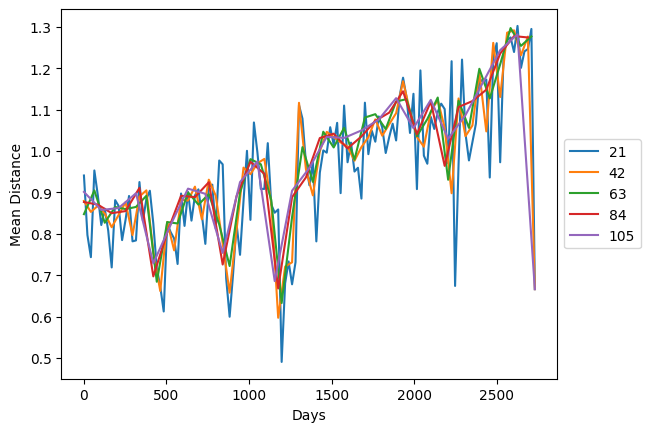

In [31]:
import math
import matplotlib.pyplot as plt
%matplotlib inline
def calc_d(x):
    x = round(x,3)
    d = math.sqrt(2 * (1 - x))
    return d
corr_dict = {}
corr_dist_dict = {}
T = 1
W = 63
x = []
y = []
for w in range(21,126,21):
    x = []
    y = []
    W = w
    for i in range(t,len(df_price),W):
            dkey = i
            corr_dict[dkey]=df_price.iloc[i:(i+W)].corr(method='pearson')
            corr_dict[dkey].fillna(1,inplace=True)
            corr_dist_dict[dkey] = corr_dict[dkey].applymap(calc_d)
            x.append(dkey)
            y.append(np.mean([abs(j) for j in corr_dist_dict[dkey].values.flatten().tolist()]))
    plt.plot(x,y)
    plt.xlabel('Days')
    plt.ylabel('Mean Distance')
    plt.legend(list(range(21,126,21)), loc='center left', bbox_to_anchor=(1, 0.5),ncol=1)
W = 63
corr_dict = {}
corr_dist_dict = {}
for i in range(t,len(df_price),W):
      dkey = i
      corr_dict[dkey]=df_price.iloc[i:(i+W)].corr(method='pearson')
      corr_dict[dkey].fillna(1,inplace=True)
      corr_dist_dict[dkey] = corr_dict[dkey].applymap(calc_d)

In [32]:
#MST Start 
elistmst_dict={}
for y in corr_dist_dict.keys():
    df_price_corr = corr_dist_dict[y]
    elistmst = []
    outdict=df_price_corr.to_dict()
    for i in outdict.keys():
        for j in outdict[i].keys():
            if (abs(outdict[i][j]) > 0 and (i>j)):
                elistmst.append([i,j,dict(weight=abs(outdict[i][j]),start=y,end=y+W-1)])
    elistmst_dict[y] = elistmst

In [35]:
import networkx as nx
import community.community_louvain as community_louvain

GMST_dict = {}
for y in elistmst_dict.keys():
    G = nx.Graph()
    elist = elistmst_dict[y]
    G.add_edges_from(elist)
    
    T = nx.minimum_spanning_tree(G)
    G = T
    
    # Add sector information to the graph nodes
    values = dfsp500.set_index('Symbol').to_dict(orient='dict')['Sector']
    for node, value in values.items():
        if node in G.nodes:
            G.nodes[node]['Sector'] = value
    
    # Compute community partition
    partition = community_louvain.best_partition(G)
    
    # Compute centralities and attributes
    deg_cent = dict(nx.degree_centrality(G))
    degree = dict(G.degree())
    close_cent = dict(nx.closeness_centrality(G))
    betw_cent = dict(nx.betweenness_centrality(G))
    
    # Set node attributes
    nx.set_node_attributes(G, partition, "community")
    nx.set_node_attributes(G, deg_cent, "degreecent")
    nx.set_node_attributes(G, degree, "degree")
    nx.set_node_attributes(G, close_cent, "closeness")
    nx.set_node_attributes(G, betw_cent, "betweenness")
    nx.set_node_attributes(G, 'start', y)
    nx.set_node_attributes(G, 'end', y + W)
    
    GMST_dict[y] = G

In [43]:
# df_list = []
# for k in GMST_dict.keys():
#     G = GMST_dict[k]
#     a = dict(G.nodes(data=True))
#     df_list.append(pd.DataFrame(a).T.reset_index())
    
# attribMST_df = pd.concat(df_list)
# attribMST_df.fillna(0,inplace=True)

# # Ensure both 'index' and 'Symbol' columns are of the same type (string)
# attribMST_df['index'] = attribMST_df['index'].astype(str)
# dfsp500['Symbol'] = dfsp500['Symbol'].astype(str)

# attribMST_df1=attribMST_df.merge(dfsp500,left_on='index',right_on='Symbol')
# print(attribMST_df1.columns)
# print(attrib_df1.columns)
# attribMST_df = attribMST_df1[['index','Sector_x','betweenness','closeness','community','degree','degreecent','start','Name']]
# attribMST_df.columns=['ticker','Sector','Betweeness','Closeness','Community','Degree','DegreeCent','start','Name']

# Collect the graph level attributes
for node in G.nodes():
    G.nodes[node]['start'] = y  # Example: ensure 'start' is set for each node
df_list = []
for k in GMST_dict.keys():
    G = GMST_dict[k]
    a = dict(G.nodes(data=True))
    df_list.append(pd.DataFrame(a).T.reset_index())
    
attribMST_df = pd.concat(df_list)
attribMST_df.fillna(0, inplace=True)

# Check available columns
print("Available columns in attribMST_df:", attribMST_df.columns)

# Ensure both 'index' and 'Symbol' columns are of the same type (string)
attribMST_df['index'] = attribMST_df['index'].astype(str)
dfsp500['Symbol'] = dfsp500['Symbol'].astype(str)

# Merge DataFrames
attribMST_df1 = attribMST_df.merge(dfsp500, left_on='index', right_on='Symbol')

# Check columns of merged DataFrame
print("Available columns in attribMST_df1:", attribMST_df1.columns)

# Select columns based on actual names
# Update column names if needed based on available columns
attribMST_df = attribMST_df1[['index', 'Sector_x', 'betweenness', 'closeness', 'community', 'degree', 'degreecent', 'start', 'Name']]
attribMST_df.columns = ['ticker', 'Sector', 'Betweeness', 'Closeness', 'Community', 'Degree', 'DegreeCent', 'start', 'Name']

################################################################################################################################
# Collect the node-level attributes for the nodes for all the windows
# df_list = []
# for k in G_dict.keys():
#     G = G_dict[k]
#     a = dict(G.nodes(data=True))  # Use G.nodes(data=True) to get node attributes as a dictionary
#     df_list.append(pd.DataFrame(a).T.reset_index())

# attrib_df = pd.concat(df_list)
# attrib_df.fillna(0, inplace=True)

# # Ensure both 'index' and 'Symbol' columns are of the same type (string)
# attrib_df['index'] = attrib_df['index'].astype(str)
# dfsp500['Symbol'] = dfsp500['Symbol'].astype(str)

# attrib_df1 = attrib_df.merge(dfsp500, left_on='index', right_on='Symbol')
# attrib_df = attrib_df1[['index', 'Sector_x', 'betweenness', 'closeness', 'community', 'degree', 'degreecent', 'start', 'Name']]
# attrib_df.columns = ['ticker', 'Sector', 'Betweeness', 'Closeness', 'Community', 'Degree', 'DegreeCent', 'start', 'Name']

Available columns in attribMST_df: Index([      'index',      'Sector',   'community',  'degreecent',
            'degree',   'closeness', 'betweenness',             1,
                  64,           127,           190,           253,
                 316,           379,           442,           505,
                 568,           631,           694,           757,
                 820,           883,           946,          1009,
                1072,          1135,          1198,          1261,
                1324,          1387,          1450,          1513,
                1576,          1639,          1702,          1765,
                1828,          1891,          1954,          2017,
                2080,          2143,          2206,          2269,
                2332,          2395,          2458,          2521,
                2584,          2647,          2710,          2773,
             'start'],
      dtype='object')
Available columns in attribMST_df1: Index([      

/var/folders/ql/zddshrpn57g78r770hdqrm6r0000gn/T/ipykernel_87737/1565660171.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  attribMST_df.fillna(0, inplace=True)


In [48]:
from scipy.stats import linregress
import numpy as np

G_valMST_dict = {}
for Y in GMST_dict.keys():
    G_val = {}
    G = GMST_dict[Y]
    G_val['nodes'] = nx.number_of_nodes(G)
    G_val['edges'] = nx.number_of_edges(G)
    G_val['AvgClustering'] = nx.average_clustering(G)
    
    try:
        G_val['AvgShortestPathLength'] = nx.average_shortest_path_length(G)
    except:
        G_val['AvgShortestPathLength'] = 99999
    
    try:
        G_val['Diameter'] = nx.diameter(G)
    except:
        G_val['Diameter'] = 99999

    degs = {}
    for n in G.nodes():
        deg = G.degree(n)
        if deg not in degs:
            degs[deg] = 0
        degs[deg] += 1
    
    items = sorted(degs.items())
    x = [k for k, v in items]
    y = [v for k, v in items]
    
    # Avoid log(0) issues
    xlog = np.array([np.log(k) for k in x if k > 0])
    ylog = np.array([np.log(v) for v in y if v > 0])
    
    if len(xlog) > 1 and len(ylog) > 1:
        slope, intercept, rvalue, pvalue, stderr = linregress(xlog, ylog)
    else:
        slope, intercept, rvalue, pvalue, stderr = (None, None, None, None, None)
    
    G_val['Slope'] = slope
    
    # Convert 'start' column to string if Y is a string
    attribMST_df['start'] = attribMST_df['start'].astype(str)
    
    # Use get() to handle missing keys
    G_val['No of Communities'] = attribMST_df.groupby(by=['start'])['Community'].nunique().get(str(Y), default=0)
    G_valMST_dict[Y] = G_val

GMST_df = pd.DataFrame(G_valMST_dict).T

/var/folders/ql/zddshrpn57g78r770hdqrm6r0000gn/T/ipykernel_87737/1371405051.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attribMST_df['start'] = attribMST_df['start'].astype(str)
/var/folders/ql/zddshrpn57g78r770hdqrm6r0000gn/T/ipykernel_87737/1371405051.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attribMST_df['start'] = attribMST_df['start'].astype(str)
/var/folders/ql/zddshrpn57g78r770hdqrm6r0000gn/T/ipykernel_87737/1371405051.py:45: SettingWithCopyWarning: 
A value is trying to be set on

The below table lists the network  properties for the networks created using the Minimum Spanning Tree Method over multiple Time Periods.

In [49]:
GMST_df

nodes  edges  AvgClustering  AvgShortestPathLength  Diameter     Slope  \
1     429.0  428.0            0.0               9.926236      25.0 -2.435376   
64    431.0  430.0            0.0              12.061469      29.0 -2.428470   
127   434.0  433.0            0.0              12.545407      29.0 -2.507191   
190   436.0  435.0            0.0              12.713993      32.0 -2.320919   
253   436.0  435.0            0.0              13.164927      31.0 -2.439023   
316   440.0  439.0            0.0              13.300155      35.0 -2.276948   
379   442.0  441.0            0.0              11.827900      37.0 -2.387343   
442   444.0  443.0            0.0               9.861896      24.0 -2.458617   
505   448.0  447.0            0.0              11.645953      29.0 -2.463907   
568   448.0  447.0            0.0              11.891499      28.0 -2.467341   
631   447.0  446.0            0.0              12.235913      31.0 -2.094244   
694   448.0  447.0            0.0              11.913181      28.0 -2.424715   
757   448.0  447.0            0.0              10.447587      26.0 -2.432507   
820   450.0  449.0            0.0              10.659094      24.0 -2.253641   
883   451.0  450.0            0.0               9.230530      25.0 -2.253835   
946   453.0  452.0            0.0               7.332630      17.0 -2.246504   
1009  455.0  454.0            0.0              11.821484      29.0 -2.416535   
1072  457.0  456.0            0.0              10.064359      28.0 -2.186943   
1135  458.0  457.0            0.0              11.347864      27.0 -2.311021   
1198  459.0  458.0            0.0              10.074930      24.0 -2.244390   
1261  468.0  467.0            0.0               9.312652      21.0 -2.094015   
1324  466.0  465.0            0.0              10.029083      25.0 -2.514522   
1387  468.0  467.0            0.0              10.290241      26.0 -2.462588   
1450  469.0  468.0            0.0               9.137390      24.0 -2.282733   
1513  470.0  469.0            0.0              11.221966      29.0 -2.336164   
1576  471.0  470.0            0.0               9.417085      27.0 -2.342989   
1639  476.0  475.0            0.0              11.457514      33.0 -2.292275   
1702  476.0  475.0            0.0              10.175843      26.0 -2.449739   
1765  480.0  479.0            0.0               9.372330      24.0 -2.444459   
1828  480.0  479.0            0.0              10.139875      25.0 -2.281612   
1891  482.0  481.0            0.0              12.786553      38.0 -2.258440   
1954  483.0  482.0            0.0              13.100917      40.0 -2.507015   
2017  484.0  483.0            0.0              12.727067      32.0 -2.471145   
2080  487.0  486.0            0.0              11.478862      31.0 -2.426947   
2143  486.0  485.0            0.0              11.657851      35.0 -2.445578   
2206  492.0  491.0            0.0              11.770603      30.0 -2.295584   
2269  494.0  493.0            0.0              14.215084      38.0 -2.300318   
2332  495.0  494.0            0.0              12.001718      29.0 -2.427775   
2395  497.0  496.0            0.0              14.901863      33.0 -2.586173   
2458  498.0  497.0            0.0              12.449468      32.0 -2.633043   
2521  498.0  497.0            0.0              17.281642      48.0 -2.257279   
2584  499.0  498.0            0.0              14.673926      34.0 -2.533893   
2647  498.0  497.0            0.0              14.444498      41.0 -2.480339   
2710  498.0  497.0            0.0              14.831867      34.0 -2.559232   

      No of Communities  
1                   0.0  
64                  0.0  
127                 0.0  
190                 0.0  
253                 0.0  
316                 0.0  
379                 0.0  
442                 0.0  
505                 0.0  
568                 0.0  
631                 0.0  
694                 0.0  
757                 0.0  
820                 0.0  
883            

# 5. Result 

## 5.1 Degree distribution and Scale Free Properties

We plotted the degree distribution histogram and also plotted the degree distribution on a log log plotted and regression fitted a line whose slope will give as the Power law exponent.The plot show that network shows scale free properties in most of the windows .The scale free nature is more evident in the Networks generated based on the Minimum Spanning Tree Method .

### Winner Take All Method

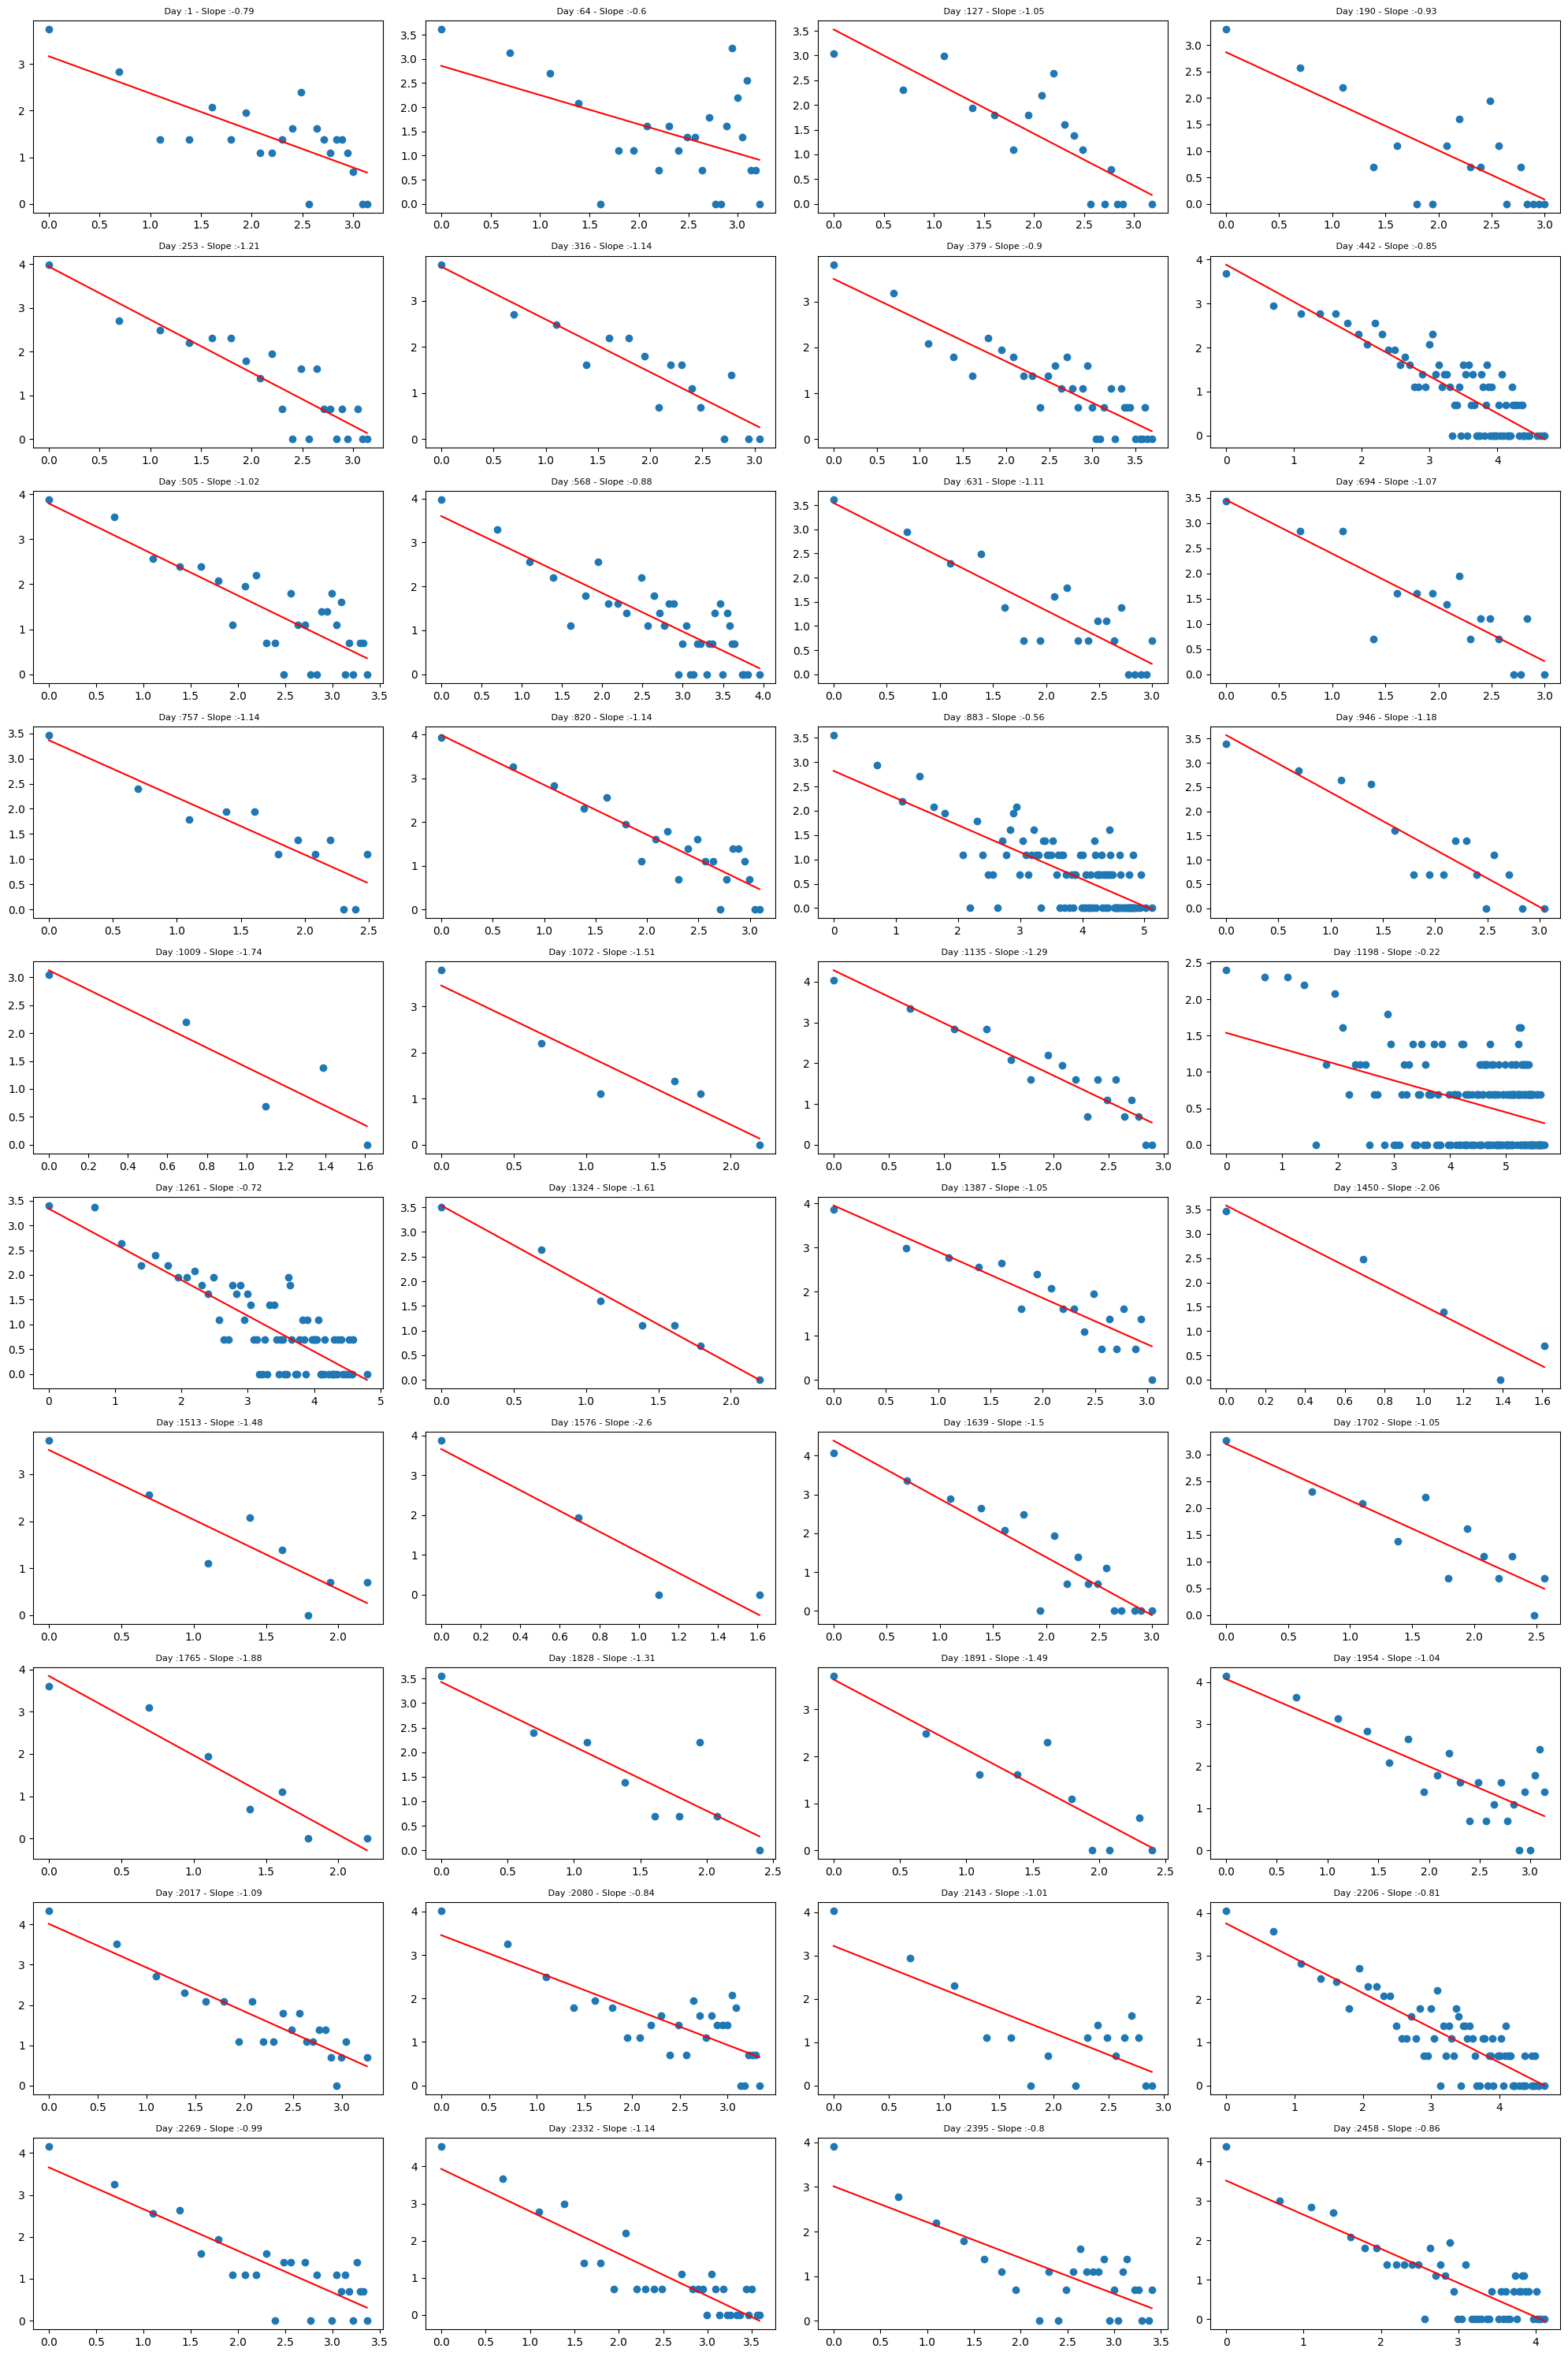

In [50]:
## Explore graph properties
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import linregress
fig, ax = plt.subplots(nrows=10,ncols=4,figsize=(20, 30))
Y = 1
for row in ax:
    for col in row:
        degs = {}
        for n in G_dict[Y].nodes() :
            deg = G_dict[Y].degree(n)
            if deg not in degs.keys() :
                degs[deg] = 0
            degs[deg] += 1
        items = sorted(degs.items())
        x= [k for (k , v ) in items ]
        y= [ v for (k ,v ) in items ]
        xlog= np.array([np.log(k) for (k , v ) in items ])
        ylog= np.array([np.log(v) for (k ,v ) in items ])
        col.scatter(xlog, ylog)
        slope,intercept,rvalue,pvalue,stderr=linregress(xlog,ylog)
        col.plot(xlog, (slope * xlog + intercept), color='red')
        #ax.set_xscale( 'log' )
        #ax.set_yscale( 'log' )
        col.set_title ( " Day :" + str(Y) + " - Slope :" + str(round(slope,2) ),fontsize=8)
        Y = Y + W
plt.tight_layout()
plt.show()

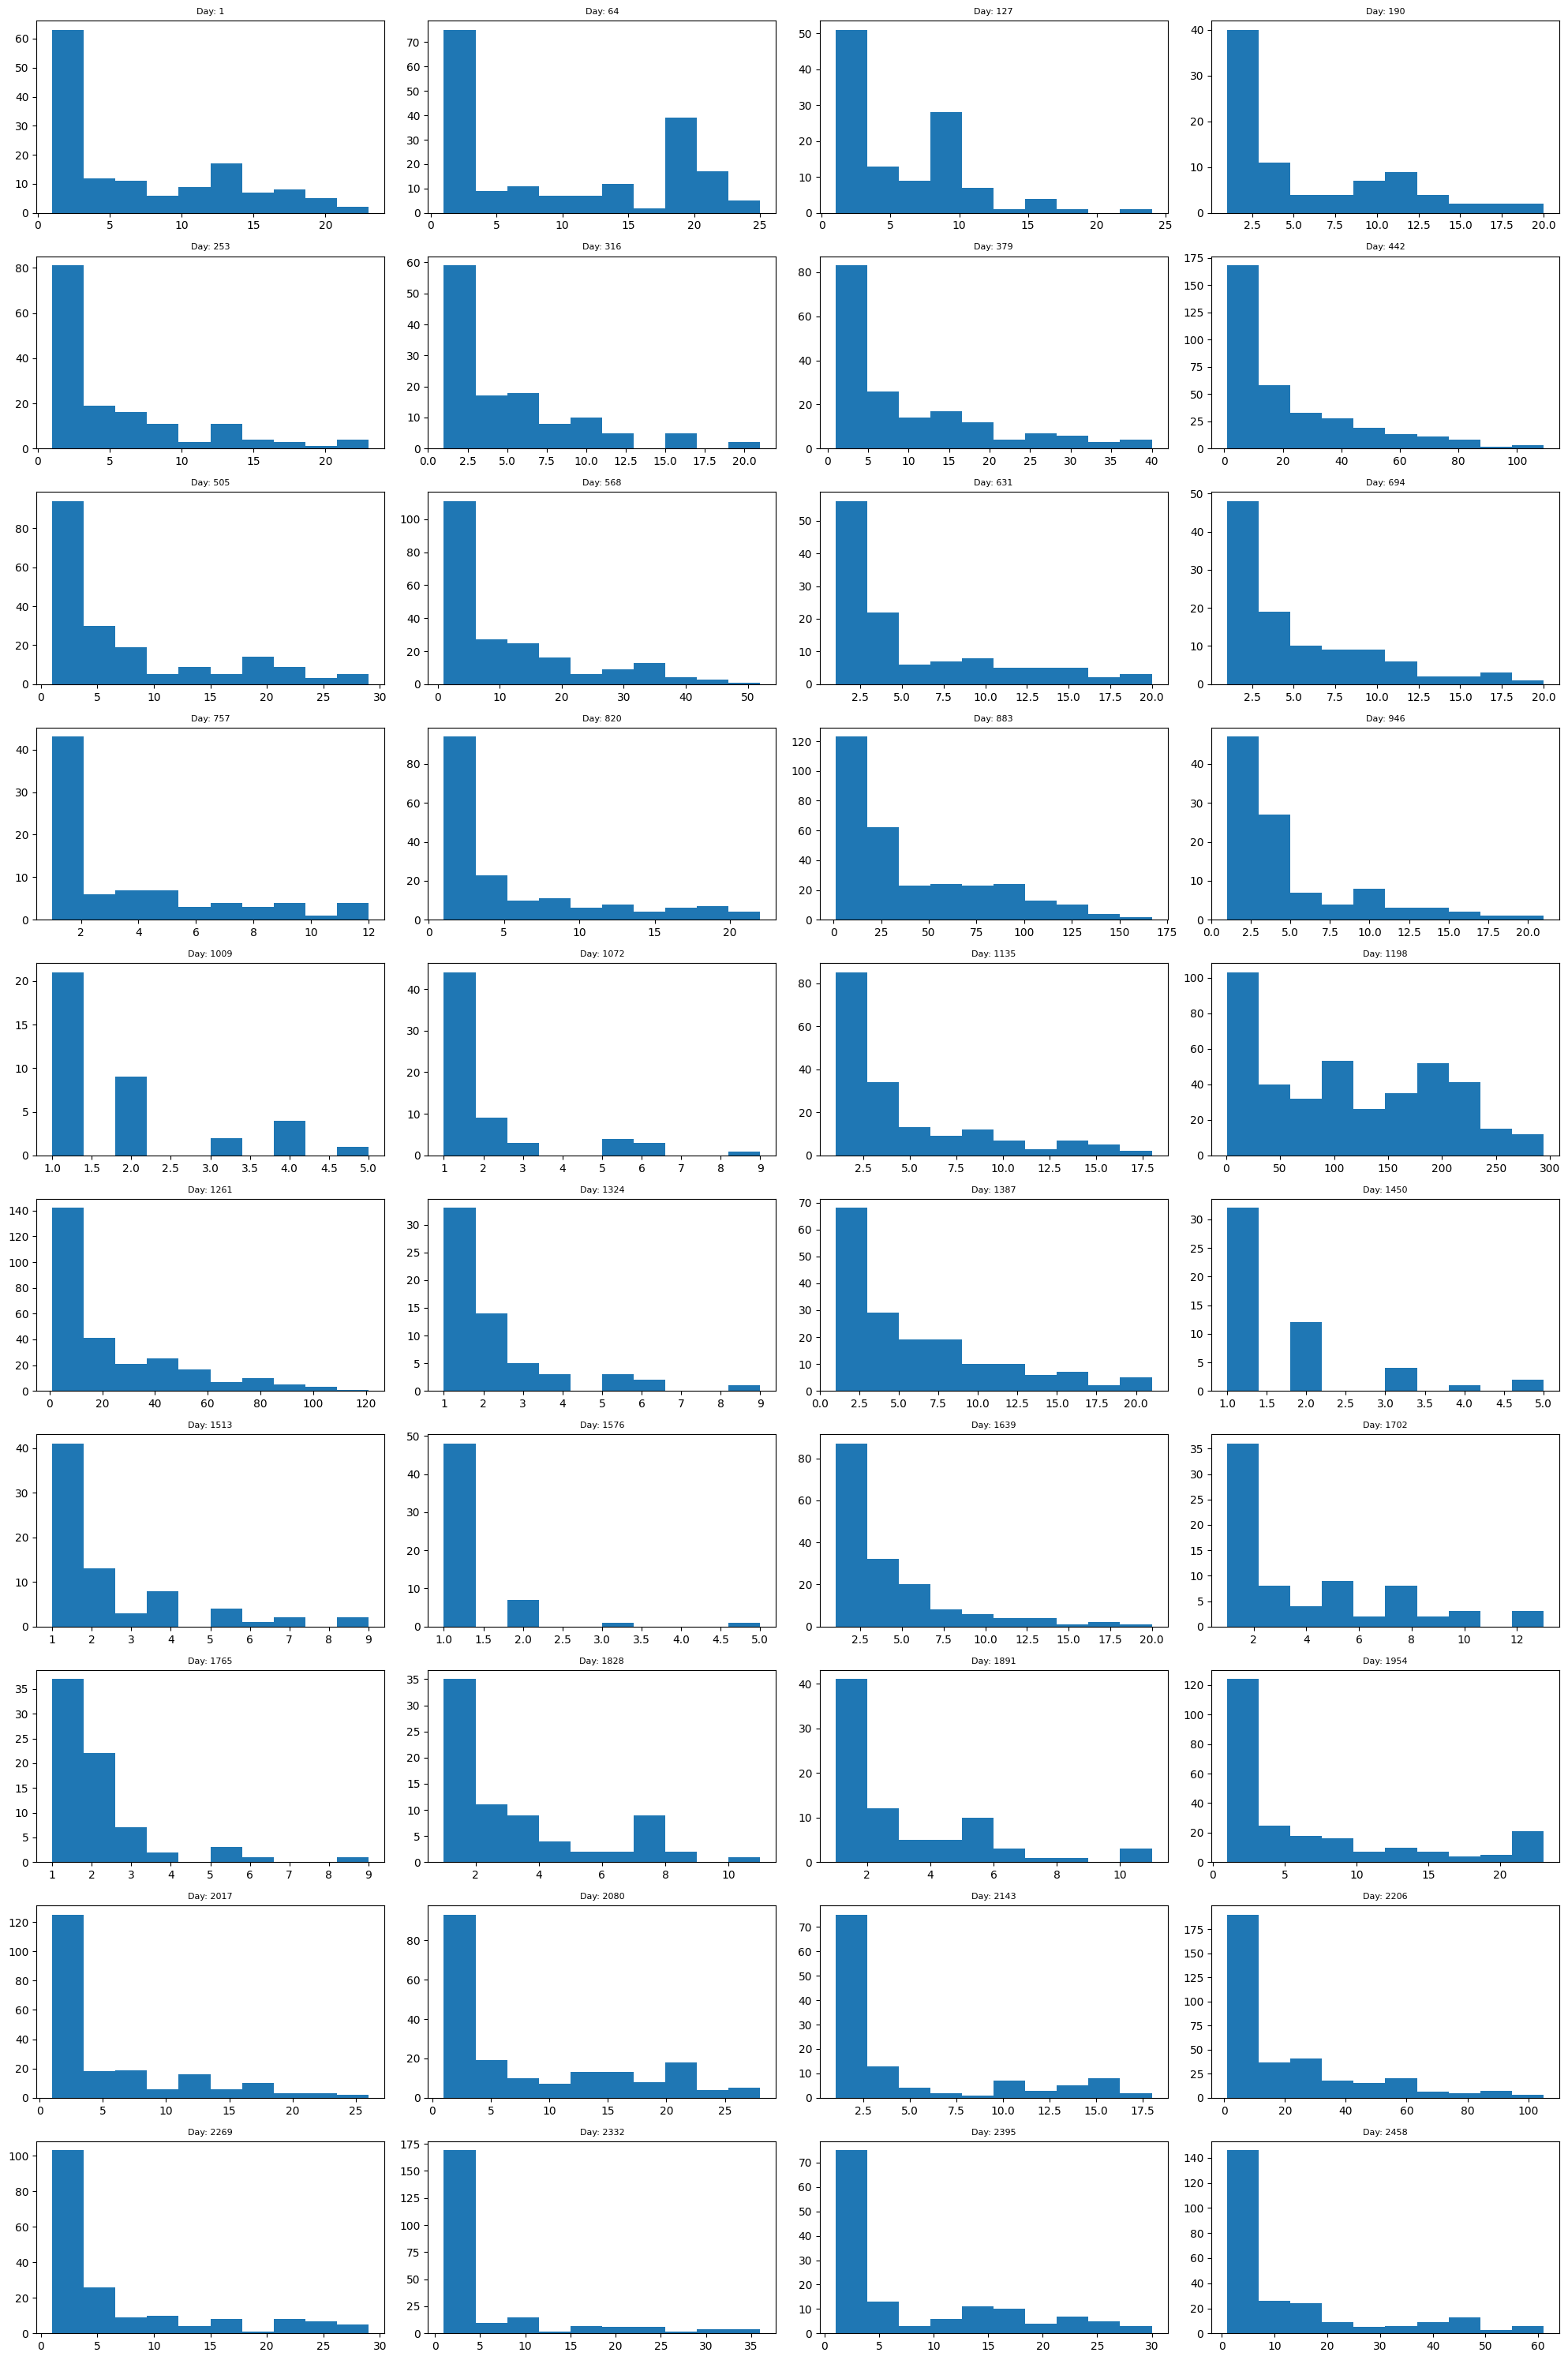

In [53]:
import matplotlib.pyplot as plt
import networkx as nx

fig, ax = plt.subplots(nrows=10, ncols=4, figsize=(20, 30))
y = 1

for row in ax:
    for col in row:
        # Convert DegreeView to a list of degrees
        deg_dist = [v for k, v in dict(nx.degree(G_dict[y])).items()]
        deg_dist.sort(reverse=True)
        pdf, bins, patch = col.hist(deg_dist, bins=10)
        col.set_title(f"Day: {y}", fontsize=8)
        y = y + W

plt.tight_layout()
plt.show()

### Minimum Spanning Tree Method

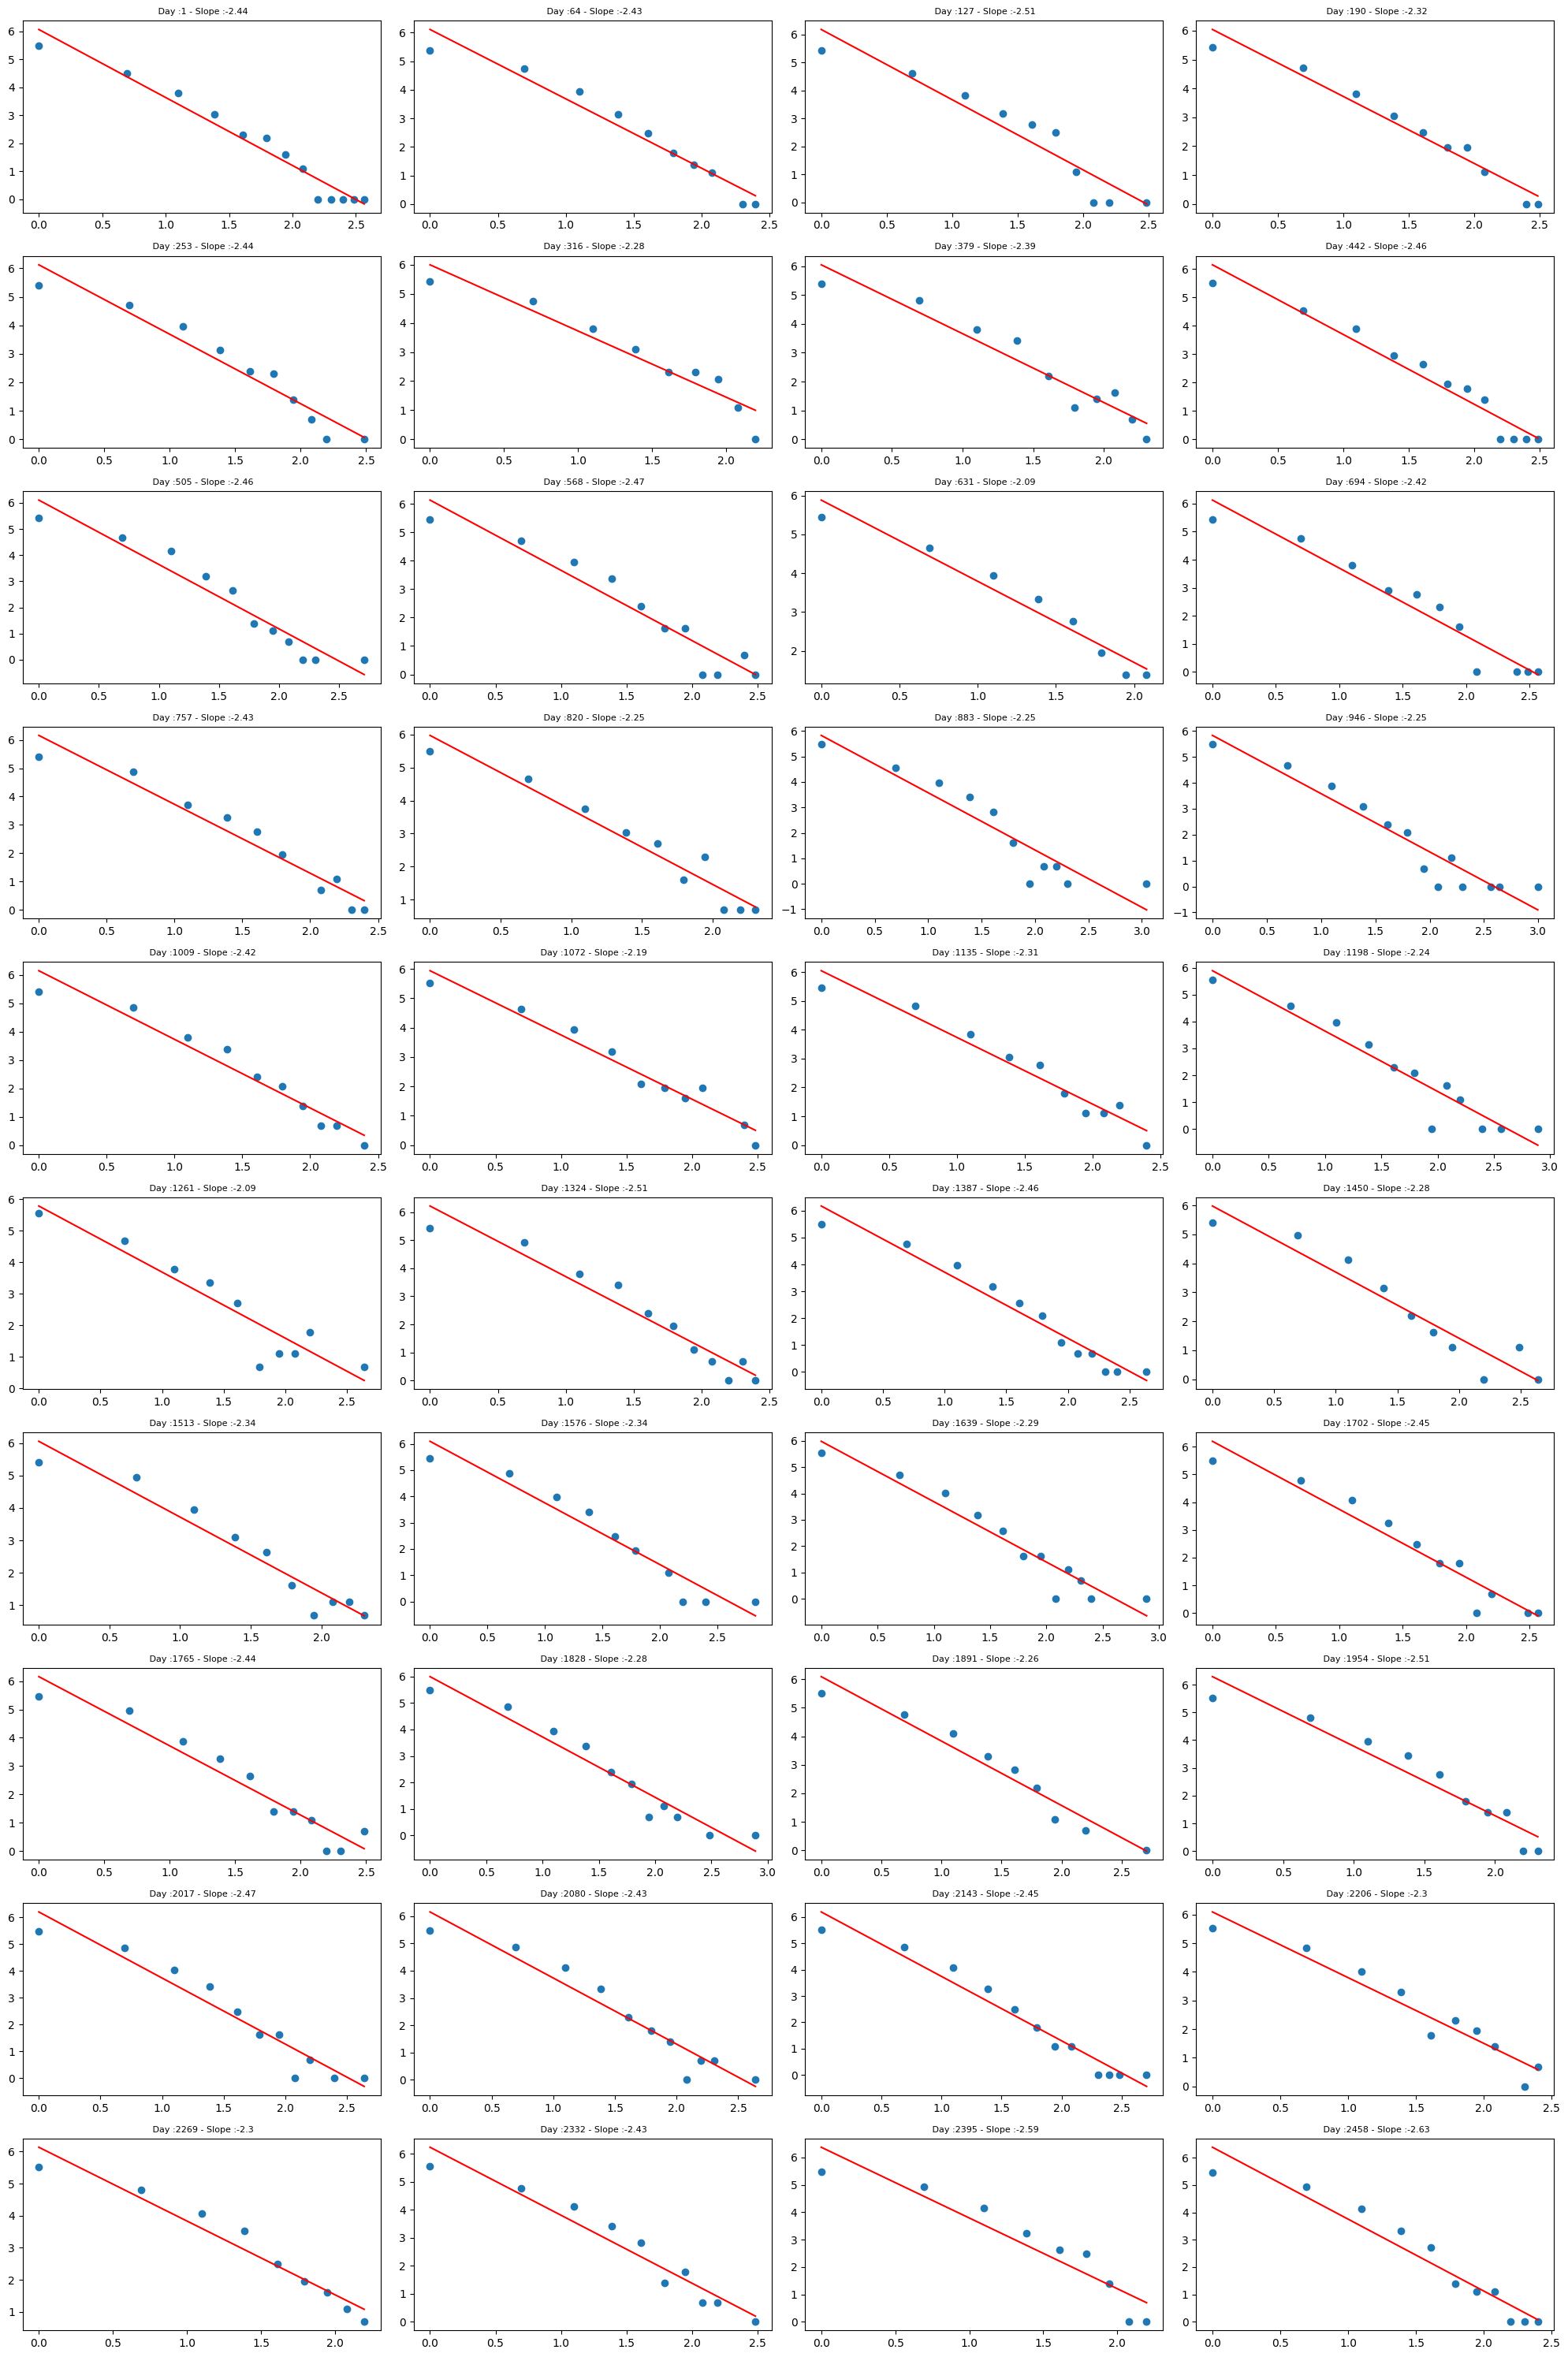

In [54]:
## Explore graph properties
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import linregress
fig, ax = plt.subplots(nrows=10,ncols=4,figsize=(20, 30))
Y = 1
for row in ax:
    for col in row:
        degs = {}
        for n in GMST_dict[Y].nodes() :
            deg = GMST_dict[Y].degree(n)
            if deg not in degs.keys() :
                degs[deg] = 0
            degs[deg] += 1
        items = sorted(degs.items())
        x= [k for (k , v ) in items ]
        y= [ v for (k ,v ) in items ]
        xlog= np.array([np.log(k) for (k , v ) in items ])
        ylog= np.array([np.log(v) for (k ,v ) in items ])
        col.scatter(xlog, ylog)
        slope,intercept,rvalue,pvalue,stderr=linregress(xlog,ylog)
        col.plot(xlog, (slope * xlog + intercept), color='red')
        #ax.set_xscale( 'log' )
        #ax.set_yscale( 'log' )
        col.set_title ( " Day :" + str(Y) + " - Slope :" + str(round(slope,2) ),fontsize=8)
        Y = Y + W
plt.tight_layout()
plt.show()

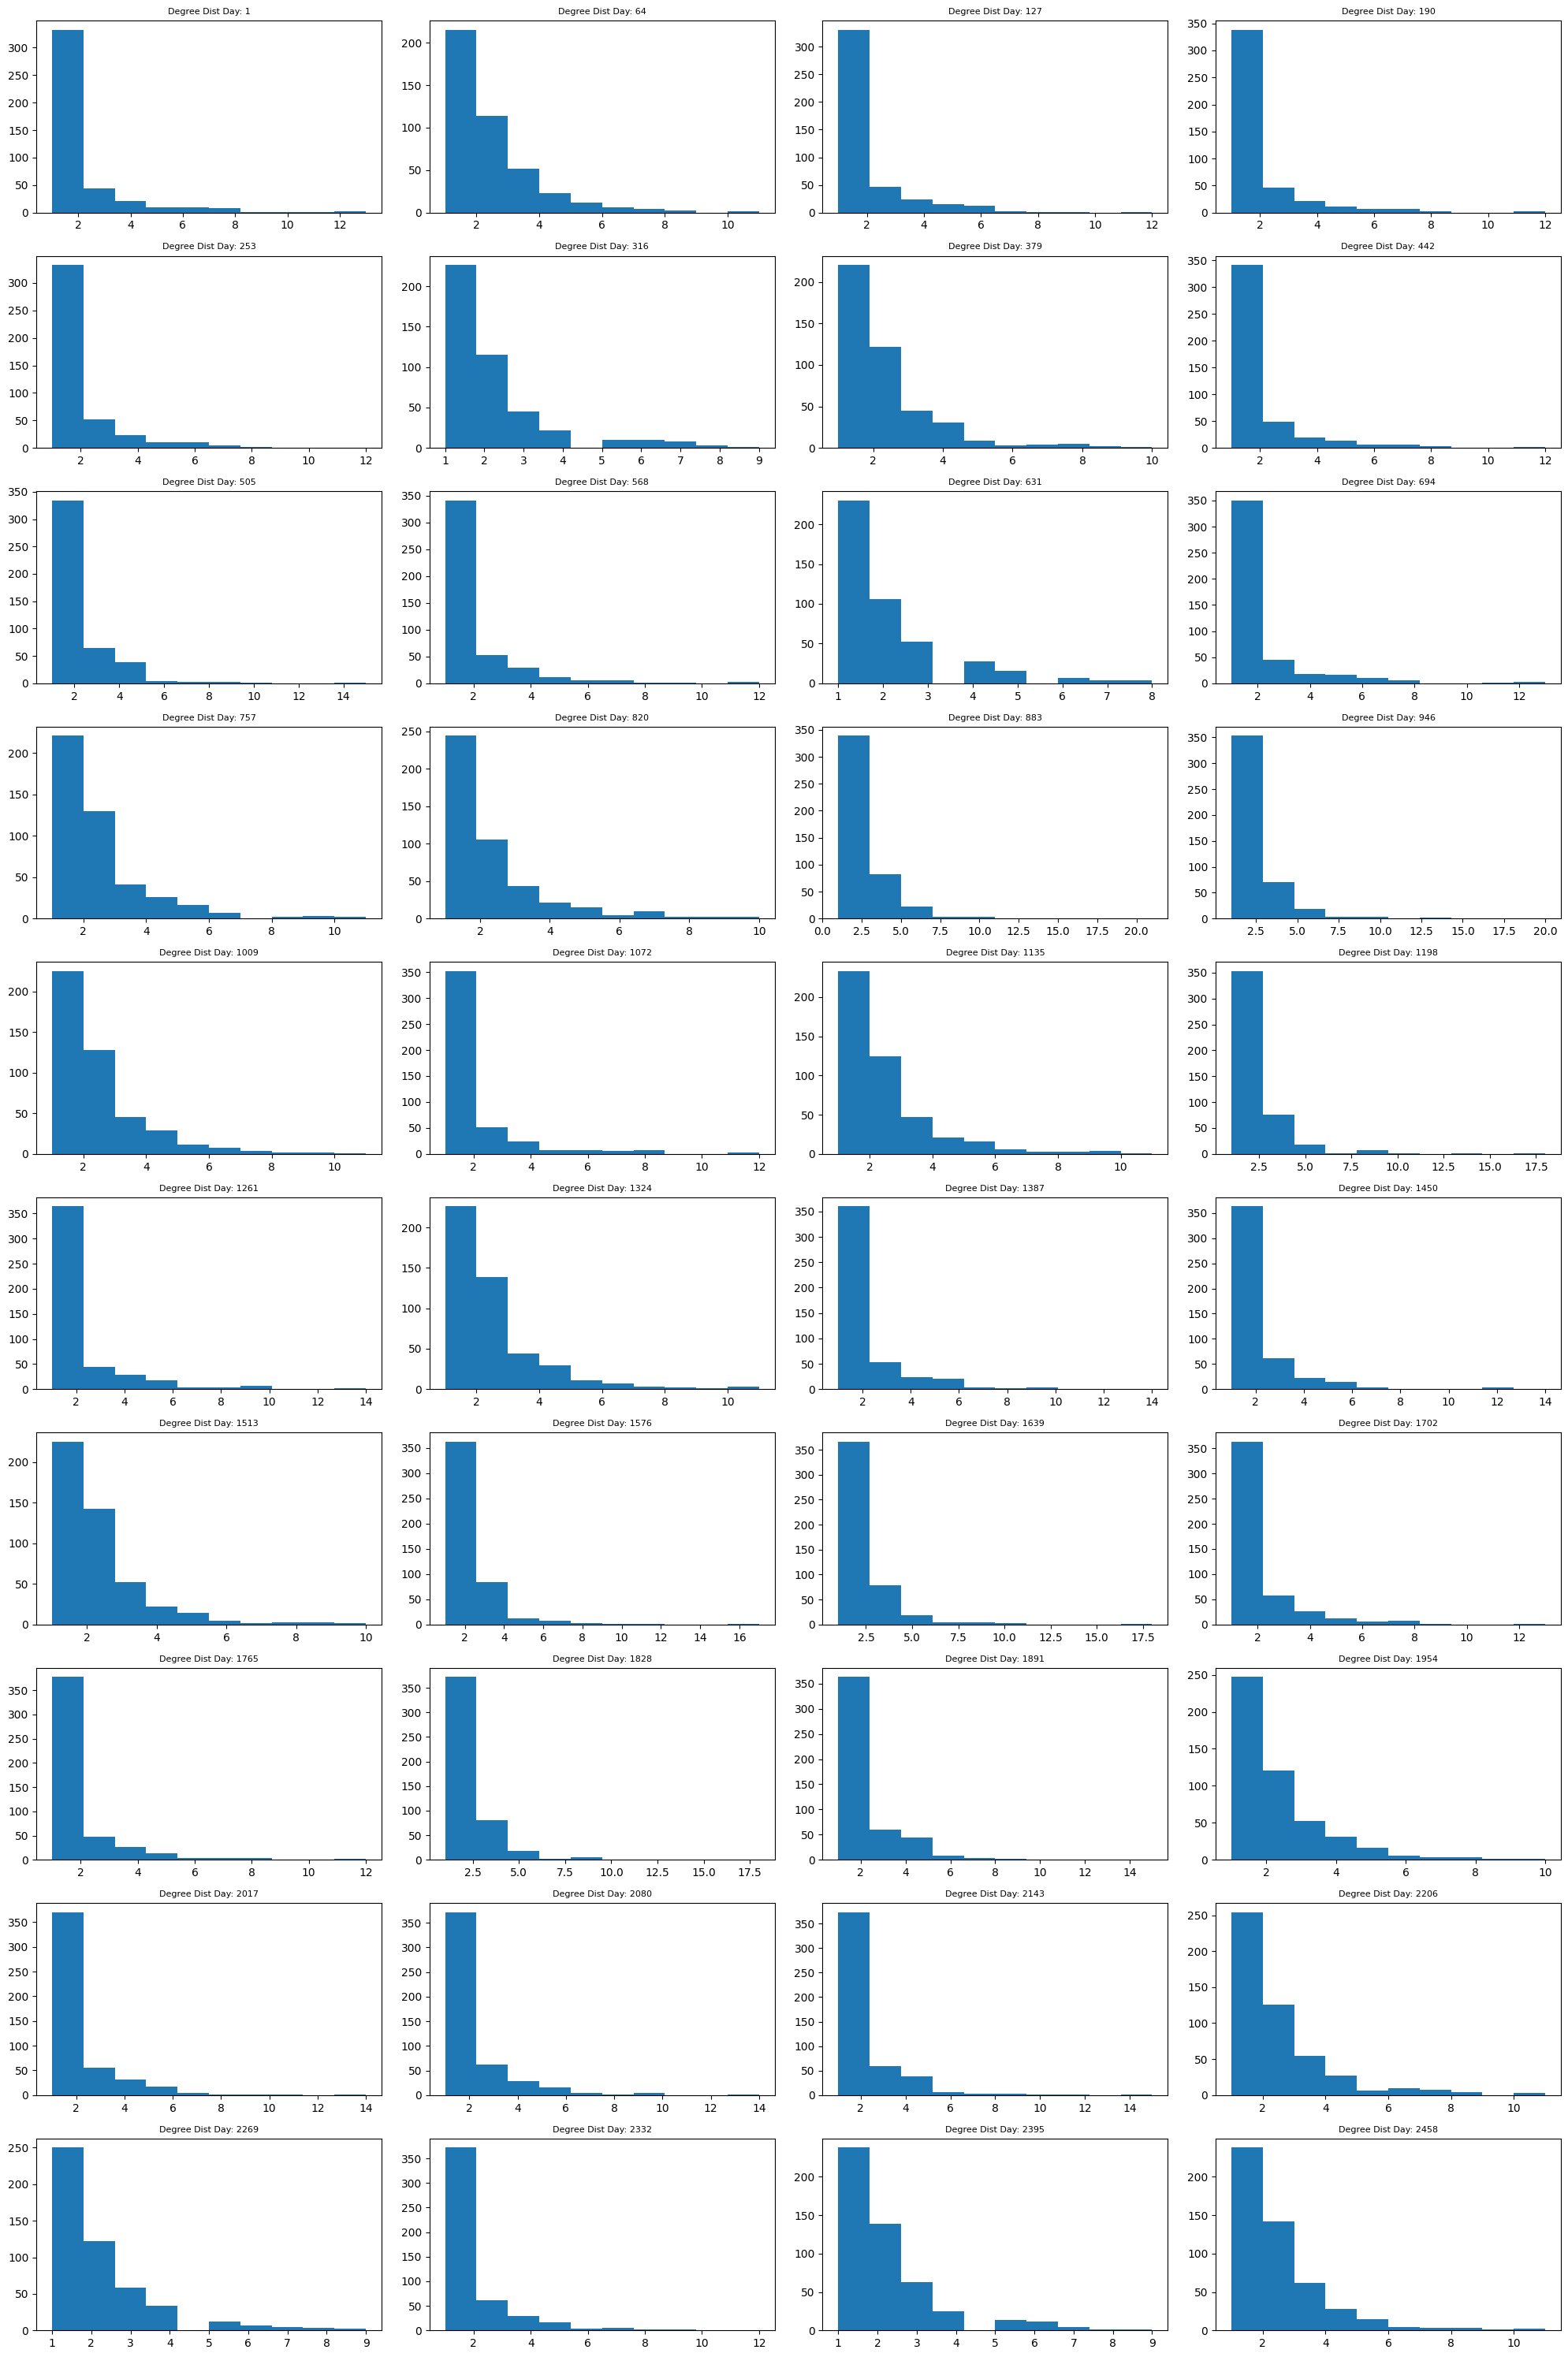

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=10, ncols=4, figsize=(20, 30))
y = 1

for row in ax:
    for col in row:
        # Convert DegreeView to a dictionary and extract the degree values
        deg_dist = [v for k, v in dict(nx.degree(GMST_dict[y])).items()]
        deg_dist.sort(reverse=True)
        pdf, bins, patch = col.hist(deg_dist, bins=10)
        col.set_title(f"Degree Dist Day: {y}", fontsize=8)
        y += W

plt.tight_layout()
plt.show()

### 5.2 Average degree of the network over time

We looked at the change in the average degree degree over time .For the networks from the Winner Take All method we can see that this varies widely overtime indicating the dynamic nature of the stock market.The peaks in the graph correspond well to major events in the market such as the 2008 - 2009 subprime crisis.However for the networks based on the MST method the Average degree is constant this is one of the key drawbacks of the MST method were major fluctuations in the market are not well represented in the network.We can also see in the plot that during normal time periods the Average Degree between the networks from both the methods is the same.

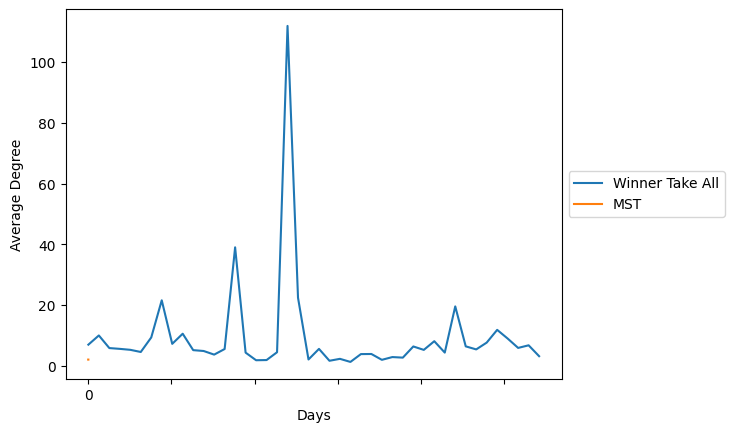

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
avgdf=attrib_df.groupby(by=['start'])['Degree'].mean()
avgdf.plot()
avgdf=attribMST_df.groupby(by=['start'])['Degree'].mean()
avgdf.plot()
plt.xlabel('Days')
plt.ylabel('Average Degree')
plt.legend(['Winner Take All','MST'], loc='center left', bbox_to_anchor=(1, 0.5),ncol=1)
plt.show()

## 5.3 High degree stocks in the network
We looked at the high degree stocks in the network at different windows to get out the important stocks which have high influence or which are a good indicator of how the stock market as whole is moving.The results are below.As we can see the stocks from financials sector have the highest degree in a number of windows .Is there a pattern here?

### Winner Take All Method

In [58]:
attrib_df.sort_values(['start','Degree'],ascending=False).groupby(['start']).head(3)[['start','ticker','Name','Degree','Sector']]

start ticker                               Name Degree  \
6922  2710    RIG                         Transocean   14.0   
6924  2710    DVN                 Devon Energy Corp.   14.0   
6927  2710    MRO                 Marathon Oil Corp.   12.0   
6810  2647    PRU               Prudential Financial   26.0   
6812  2647    UNM                         Unum Group   26.0   
6809  2647    PNC             PNC Financial Services   25.0   
6668  2584    AEE                        Ameren Corp   18.0   
6676  2584     ES                  Eversource Energy   18.0   
6678  2584    LNT                Alliant Energy Corp   18.0   
6459  2521     MS                     Morgan Stanley   41.0   
6457  2521    DFS        Discover Financial Services   40.0   
6394  2521      O          Realty Income Corporation   37.0   
6121  2458    AMP               Ameriprise Financial   61.0   
6206  2458    MCO                       Moody's Corp   58.0   
6154  2458    ETN                  Eaton Corporation   57.0   
6001  2395      C                     Citigroup Inc.   30.0   
6010  2395    PRU               Prudential Financial   30.0   
6006  2395     MS                     Morgan Stanley   29.0   
5807  2332     MS                     Morgan Stanley   36.0   
5814  2332    PNC             PNC Financial Services   35.0   
5804  2332     BK  The Bank of New York Mellon Corp.   33.0   
5603  2269    BBT                   BB&T Corporation   29.0   
5613  2269    PNC             PNC Financial Services   28.0   
5614  2269    PRU               Prudential Financial   28.0   
5244  2206    HON               Honeywell Int'l Inc.  105.0   
5271  2206    WFC                        Wells Fargo   97.0   
5234  2206  BRK.B                 Berkshire Hathaway   96.0   
5129  2143    BXP                  Boston Properties   18.0   
5135  2143    REG        Regency Centers Corporation   17.0   
5132  2143    FRT    Federal Realty Investment Trust   16.0   
4987  2080    AMP               Ameriprise Financial   28.0   
5006  2080    STI                     SunTrust Banks   27.0   
5007  2080    WFC                        Wells Fargo   27.0   
4735  2017    AMP               Ameriprise Financial   26.0   
4749  2017    MET                       MetLife Inc.   26.0   
4772  2017    USB                       U.S. Bancorp   21.0   
4483  1954    AEE                        Ameren Corp   23.0   
4488  1954      D                 Dominion Resources   23.0   
4495  1954    LNT                Alliant Energy Corp   23.0   
4390  1891    CMS                         CMS Energy   11.0   
4393  1891    SCG                         SCANA Corp   10.0   
4395  1891    XEL                    Xcel Energy Inc   10.0   
4330  1828    AMP               Ameriprise Financial   11.0   
4337  1828    PRU               Prudential Financial    8.0   
4341  1828    UNM                         Unum Group    8.0   
4248  1765    WFC                        Wells Fargo    9.0   
4246  1765      L                        Loews Corp.    6.0   
4241  1765    SCG                         SCANA Corp    5.0   
4167  1702    PEG       Public Serv. Enterprise Inc.   13.0   
4170  1702    WEC               Wec Energy Group Inc   13.0   
4179  1702    UDR                            UDR Inc   12.0   
4029  1639    PFG          Principal Financial Group   20.0   
4008  1639    WEC               Wec Energy Group Inc   18.0   
4005  1639    LNT                Alliant Energy Corp   17.0   
3954  1576    LNC                   Lincoln National    5.0   
3986  1576    PRU               Prudential Financial    3.0   
3948  1576    AME                         AMETEK Inc    2.0   
3876  1513    SCG                         SCANA Corp    9.0   
3878  1513    XEL                    Xcel Energy Inc    9.0   
3871  1513    AEP            American Electric Power    7.0   
3827  1450    OXY               Occidental Petroleum    5.0   
3839  1450    XEL                    Xcel Energy Inc    5.0   
3820  1450    IVZ                   

### Minimum Spanning Tree Method

In [59]:
attribMST_df.sort_values(['start','Degree'],ascending=False).groupby(['start']).head(3)[['start','ticker','Name','Degree','Sector']]

start ticker                  Name Degree                  Sector
20252  2710    HON  Honeywell Int'l Inc.      9             Industrials
20246  2710    HCP              HCP Inc.      7             Real Estate
20418  2710    RIG            Transocean      7                  Energy
6382      0    HON  Honeywell Int'l Inc.     21             Industrials
6951      0   PCAR           PACCAR Inc.     20             Industrials
8831      0    SNA          Snap-On Inc.     18  Consumer Discretionary

We plotted the count of the sector of the high degree stock in the windows and we can see that Finance  stocks definetly are the center of the market network.This kind of makes sense since Finance stocks are structurally dependent on what happens in the other sectors and we can expect them to be the important stocks which are correlated to many of the other stocks in the market. 

In [60]:
df1=attrib_df.sort_values(['start','Degree'],ascending=False).groupby(['start']).head(3).groupby(['Sector']).count()['ticker']
df2=attribMST_df.sort_values(['start','Degree'],ascending=False).groupby(['start']).head(3).groupby(['Sector']).count()['ticker']
df3=pd.concat([df1, df2], axis=1).fillna(0)
df3.columns = ['t1','t2']

[]

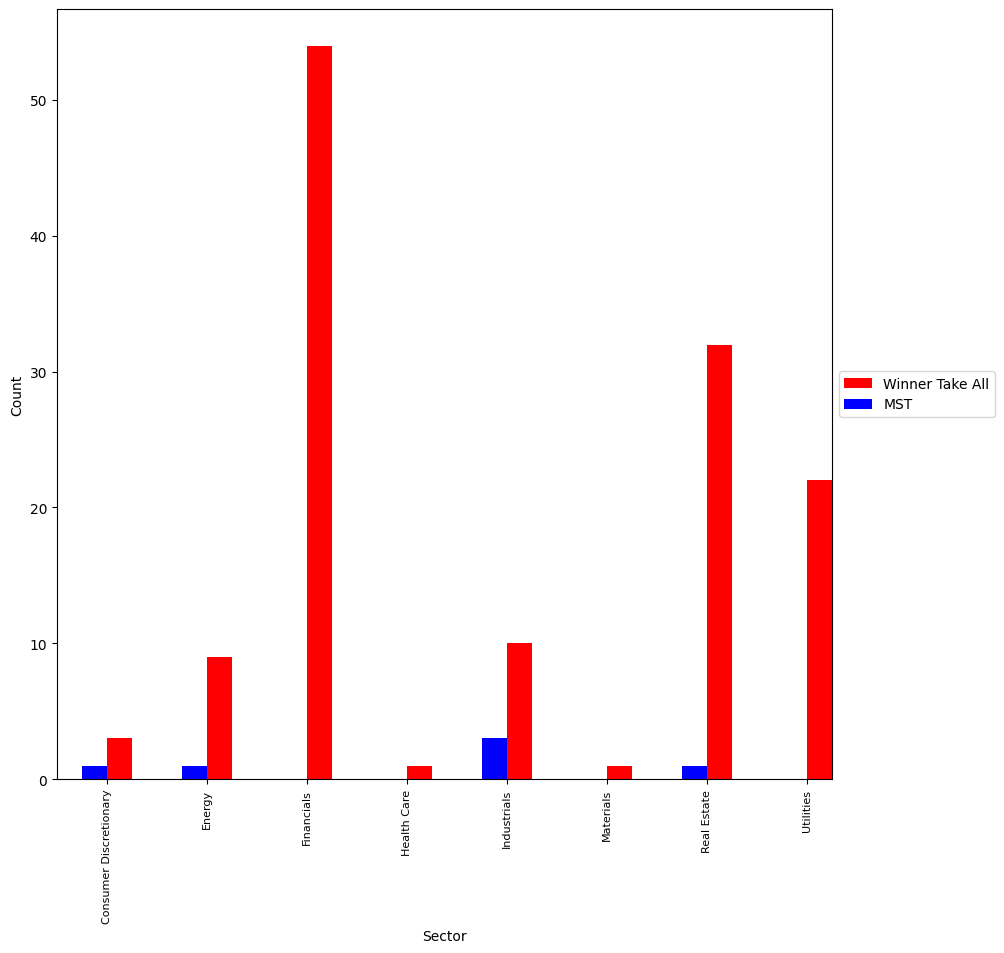

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(10,10))
df3['t1'].plot(kind='bar',color='red',  position=0, width=0.25)
df3['t2'].plot(kind='bar',color='blue',  position=1, width=0.25)
plt.xticks(rotation=90,fontsize=8)
plt.ylabel('Count')
plt.legend(['Winner Take All','MST'], loc='center left', bbox_to_anchor=(1, 0.5),ncol=1)
plt.plot()

## 5.4 Stocks With High Betweenness Centrality
We looked at the stocks with high betweeness Centrality in the network at different windows to get out the important stocks which because of the position in the network will be good predictors in the movement of prices of the stocks.The results are below.As we can see financials stocks still lead in most periods .

### Winner Take All Method

In [62]:
attrib_df.sort_values(['start','Betweeness'],ascending=False).groupby(['start']).head(3)[['start','ticker','Name','Betweeness','Sector']]

start ticker                              Name Betweeness  \
6912  2710   FOXA  Twenty-First Century Fox Class A   0.007527   
7020  2710   HOLX                           Hologic    0.00602   
6973  2710   MDLZ            Mondelez International   0.004457   
6812  2647    UNM                        Unum Group   0.011563   
6810  2647    PRU              Prudential Financial   0.007078   
6822  2647   SCHW        Charles Schwab Corporation   0.005239   
6712  2584    LNC                  Lincoln National   0.007059   
6718  2584     GS               Goldman Sachs Group   0.006757   
6717  2584   ZION                     Zions Bancorp   0.005617   
6356  2521    MMC                  Marsh & McLennan   0.263369   
6355  2521      A          Agilent Technologies Inc   0.242022   
6502  2521    BDX                  Becton Dickinson   0.241476   
6219  2458    DOV                       Dover Corp.   0.096814   
6272  2458    NOV       National Oilwell Varco Inc.   0.050621   
6154  2458    ETN                 Eaton Corporation   0.044627   
6010  2395    PRU              Prudential Financial    0.01692   
6021  2395    AMP              Ameriprise Financial   0.008896   
6001  2395      C                    Citigroup Inc.   0.005486   
5857  2332    DHR                     Danaher Corp.    0.11406   
5896  2332    XYL                        Xylem Inc.   0.110987   
5861  2332     PH                   Parker-Hannifin   0.100336   
5605  2269      C                    Citigroup Inc.   0.015367   
5654  2269    COF             Capital One Financial   0.013035   
5666  2269   MSFT                   Microsoft Corp.   0.010677   
5244  2206    HON              Honeywell Int'l Inc.   0.179281   
5290  2206    KMB                    Kimberly-Clark   0.102551   
5496  2206    XOM                 Exxon Mobil Corp.   0.097637   
5112  2143    UTX               United Technologies   0.002849   
5151  2143    NOC            Northrop Grumman Corp.   0.002849   
5119  2143    LNT               Alliant Energy Corp   0.002634   
4996  2080    ITW               Illinois Tool Works   0.024448   
4914  2080    BEN                Franklin Resources   0.021803   
4985  2080     PH                   Parker-Hannifin   0.017168   
4748  2017    BEN                Franklin Resources   0.040643   
4809  2017    EMR          Emerson Electric Company   0.039177   
4856  2017    ROP                  Roper Industries   0.036919   
4481  1954    MMM                        3M Company   0.055875   
4539  1954    MET                      MetLife Inc.   0.046139   
4520  1954    PFG         Principal Financial Group   0.029066   
4433  1891    HON              Honeywell Int'l Inc.   0.062975   
4404  1891    TMK                   Torchmark Corp.   0.045095   
4417  1891    PNC            PNC Financial Services   0.042089   
4339  1828    TMK                   Torchmark Corp.   0.088856   
4327  1828    MMC                  Marsh & McLennan   0.086326   
4330  1828    AMP              Ameriprise Financial   0.081451   
4248  1765    WFC                       Wells Fargo   0.037167   
4246  1765      L                       Loews Corp.   0.023865   
4257  1765   CINF              Cincinnati Financial   0.018779   
4167  1702    PEG      Public Serv. Enterprise Inc.   0.013239   
4171  1702    AIV       Apartment Investment & Mgmt   0.011686   
4170  1702    WEC              Wec Energy Group Inc   0.011629   
4029  1639    PFG         Principal Financial Group   0.108913   
4021  1639    ROK          Rockwell Automation Inc.   0.060219   
4041  1639    MRO                Marathon Oil Corp.   0.042164   
3954  1576    LNC                  Lincoln National   0.010065   
3952  1576    AMP              Ameriprise Financial   0.006494   
3951  1576    AMG     Affiliated Managers Group Inc   0.003896   
3891  1513     GS               Goldman Sachs Group   0.044901   
3925  1513    LNC                  Lincoln National   0.041667   
3923  1513    USB                      U.S. B

### Minimum Spanning Tree Method

In [63]:
attribMST_df.sort_values(['start','Betweeness'],ascending=False).groupby(['start']).head(3)[['start','ticker','Name','Betweeness','Sector']]

start ticker                  Name Betweeness       Sector
20091  2710    BEN    Franklin Resources   0.649015   Financials
20277  2710    IVZ          Invesco Ltd.   0.584231   Financials
20252  2710    HON  Honeywell Int'l Inc.   0.474427  Industrials
12233     0    AMP  Ameriprise Financial   0.838081   Financials
11286     0    AMP  Ameriprise Financial   0.807685   Financials
6382      0    HON  Honeywell Int'l Inc.   0.775184  Industrials

We plotted the count of the sector of the high betweenness stocks in the windows and we can see that Finance stocks still lead however industrials come in number two.

In [64]:
df1=attrib_df.sort_values(['start','Betweeness'],ascending=False).groupby(['start']).head(3).groupby(['Sector']).count()['ticker']
df2=attribMST_df.sort_values(['start','Betweeness'],ascending=False).groupby(['start']).head(3).groupby(['Sector']).count()['ticker']
df3=pd.concat([df1, df2], axis=1).fillna(0)
df3.columns = ['t1','t2']

[]

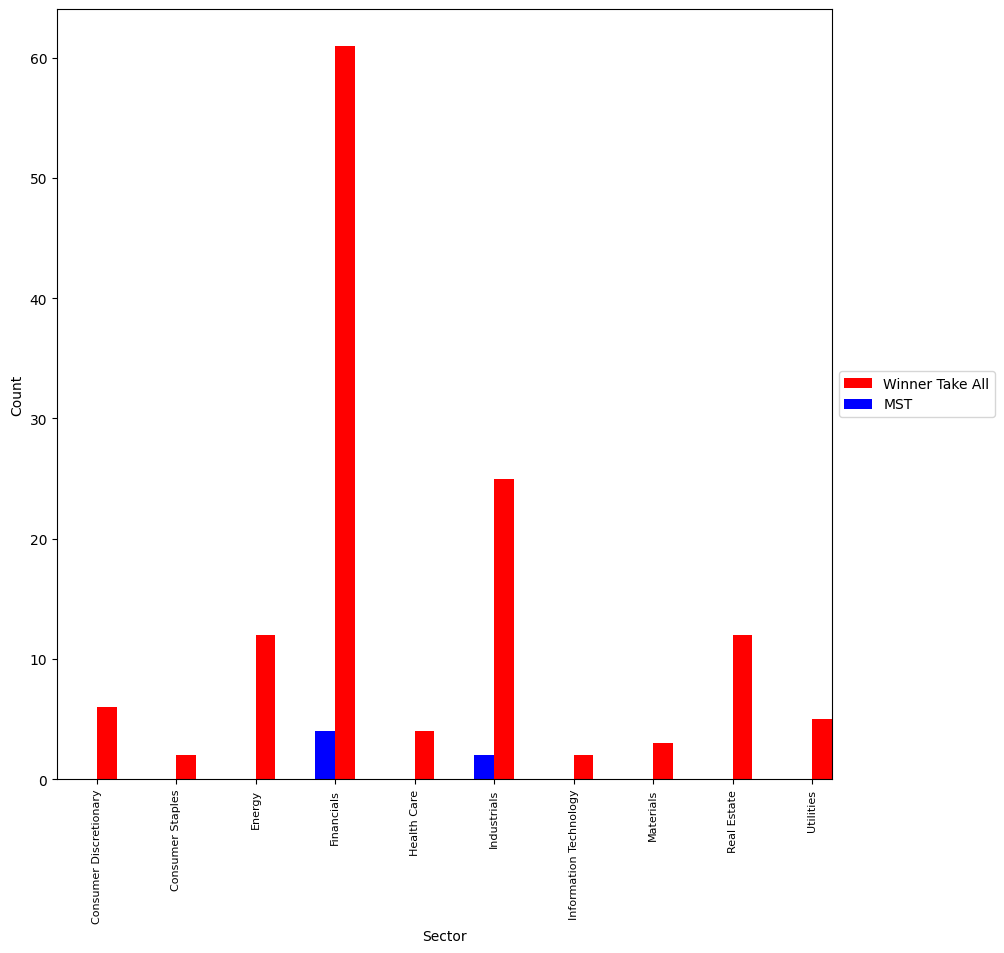

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(10,10))
df3['t1'].plot(kind='bar',color='red',  position=0, width=0.25)
df3['t2'].plot(kind='bar',color='blue',  position=1, width=0.25)
plt.xticks(rotation=90,fontsize=8)
plt.ylabel('Count')
plt.legend(['Winner Take All','MST'], loc='center left', bbox_to_anchor=(1, 0.5),ncol=1)
plt.plot()

## 5.5. Communities detected over time

We looked at the number of communities detected over different periods.The variation in the number of communities denotes the dynamic nature of the market where a number of new communities of stocks are formed in each window and each of which can die or continue into subsequent periods

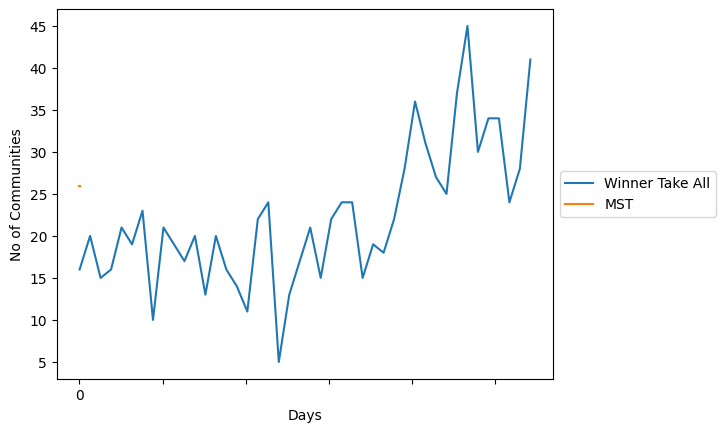

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline
cdf=attrib_df.groupby(by=['start'])['Community'].nunique()
cdf.plot()
cdf=attribMST_df.groupby(by=['start'])['Community'].nunique()
cdf.plot()
plt.legend(['Winner Take All','MST'], loc='center left', bbox_to_anchor=(1, 0.5),ncol=1)
plt.xlabel('Days')
plt.ylabel('No of Communities')
plt.show()

## 5.6 Jaccard Similarity of Communities Detected with Sector Code
One the key points we wanted to look as part of the project was too see if the network created based on the stock prizes has any relationship to the SIC(Standard Industry classification Code) of these stocks .That is do the Financial,Industrial and IT  stocks trade in a group ?.So to study the similarity of the communities detected with the SIC code of these stocks in the SP500 we computed the Jaccard similarity coefficient of these communities in each of the time windows with the stock list grouped by industry code.

We converted the stock list in  the communities detected and the stock list as per the SIC code into a binary matrix.The presence of the stock in the community/group is denoted by 1 and the absence by 0.

Given two objects, A and B, each with n binary attributes, the Jaccard coefficient is a useful measure of the overlap that A and B share with their attributes. Each attribute of A and B can either be 0 or 1. The total number of each combination of attributes for both A and B are specified as follows:

    - M_11 represents the total number of attributes where A and B both have a value of 1.
    - M_01 represents the total number of attributes where the attribute of A is 0 and the attribute of B is 1.
    - M_10 represents the total number of attributes where the attribute of A is 1 and the attribute of B is 0.
    - M_00 represents the total number of attributes where A and B both have a value of 0.

Each attribute must fall into one of these four categories, meaning that
M_11 + M_01 + M_10 + M_00 = n.

The Jaccard similarity coefficient, J, is given as

$$J = {M_{11} \over M_{01} + M_{10} + M_{11}}$$

So if a particular community has a Jaccard coefficient of more than 0.25 with the the group of stocks classified by the SIC code we classified the community as that particular SIC code .The plot is below and provides a interesting result.

So as we can visuvalize some sectors are well correlated or connected and the communities detected clearly indicate these stocks trade in groups over different periods

    Finance
    Real Estate
    Utilities
    Energy
    Telecommunication
    Industrials
    
However , the interesting result is that there are certain sectors which don't trade as groups .We don't see any communities being detected in these sectors.This seems to indicate that these sectors has various other stock specific factors at play in the market and they don't generally trade as a group

    Information Technology
    Materials
    Consumer Staples
    Consumer Discretionary
    Health Care

In [67]:
cmatrix = attrib_df.groupby(by=['start','Community','ticker'])['ticker'].count().unstack()
cmatrix.fillna(0,inplace=True)
smatrix = attrib_df.groupby(by=['Sector','ticker'])['ticker'].count().unstack()
smatrix.fillna(0,inplace=True)
smatrix[smatrix != 0] = 1
csmatrix=pd.concat([smatrix,cmatrix])
jval = {}
for idxs,rows  in smatrix.iterrows():
    xlist = []
    ylist = []
    for idxc,rowc in cmatrix.iterrows():
        x = [int(i) for i in rows]
        y = [int(i) for i in rowc]
        jc = (np.double(np.bitwise_and(x, y).sum()) / np.double(np.bitwise_or(x, y).sum()))
        if jc > 0.25:
            xlist.append(idxc[0])
            ylist.append(jc)
    jval[idxs] = [xlist,ylist]

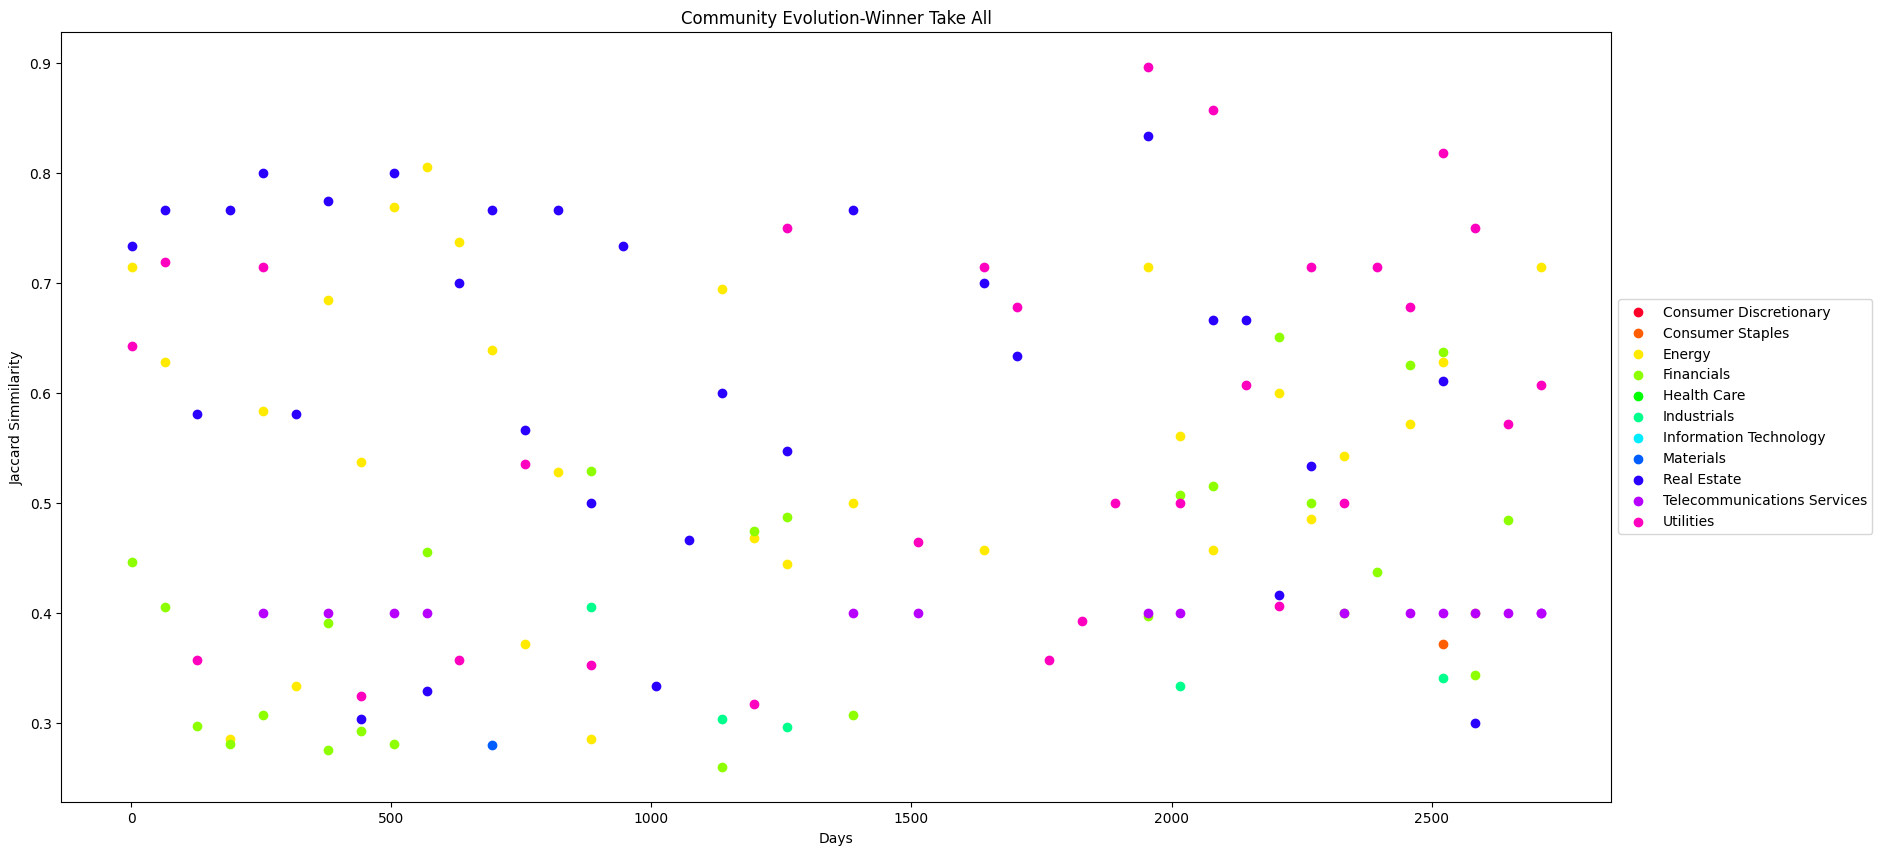

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,10))
cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = 11
colors = [cm(i) for i in np.linspace(0,1,NUM_COLORS)]
color_dict=dict(zip(list(jval.keys()), colors))
for key in jval:
    x = jval[key][0]
    y = jval[key][1]
    plt.scatter(x,y,color=color_dict[key],label=key)
    
#plt.legend(list(jval.keys()), loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Days')
plt.ylabel('Jaccard Simmilarity')
plt.title('Community Evolution-Winner Take All')
plt.show()

In [69]:
cmatrix = attribMST_df.groupby(by=['start','Community','ticker'])['ticker'].count().unstack()
cmatrix.fillna(0,inplace=True)
smatrix = attribMST_df.groupby(by=['Sector','ticker'])['ticker'].count().unstack()
smatrix.fillna(0,inplace=True)
smatrix[smatrix != 0] = 1
csmatrix=pd.concat([smatrix,cmatrix])
jval = {}
for idxs,rows  in smatrix.iterrows():
    xlist = []
    ylist = []
    for idxc,rowc in cmatrix.iterrows():
        x = [int(i) for i in rows]
        y = [int(i) for i in rowc]
        jc = (np.double(np.bitwise_and(x, y).sum()) / np.double(np.bitwise_or(x, y).sum()))
        if jc > 0.25:
            xlist.append(idxc[0])
            ylist.append(jc)
    jval[idxs] = [xlist,ylist]

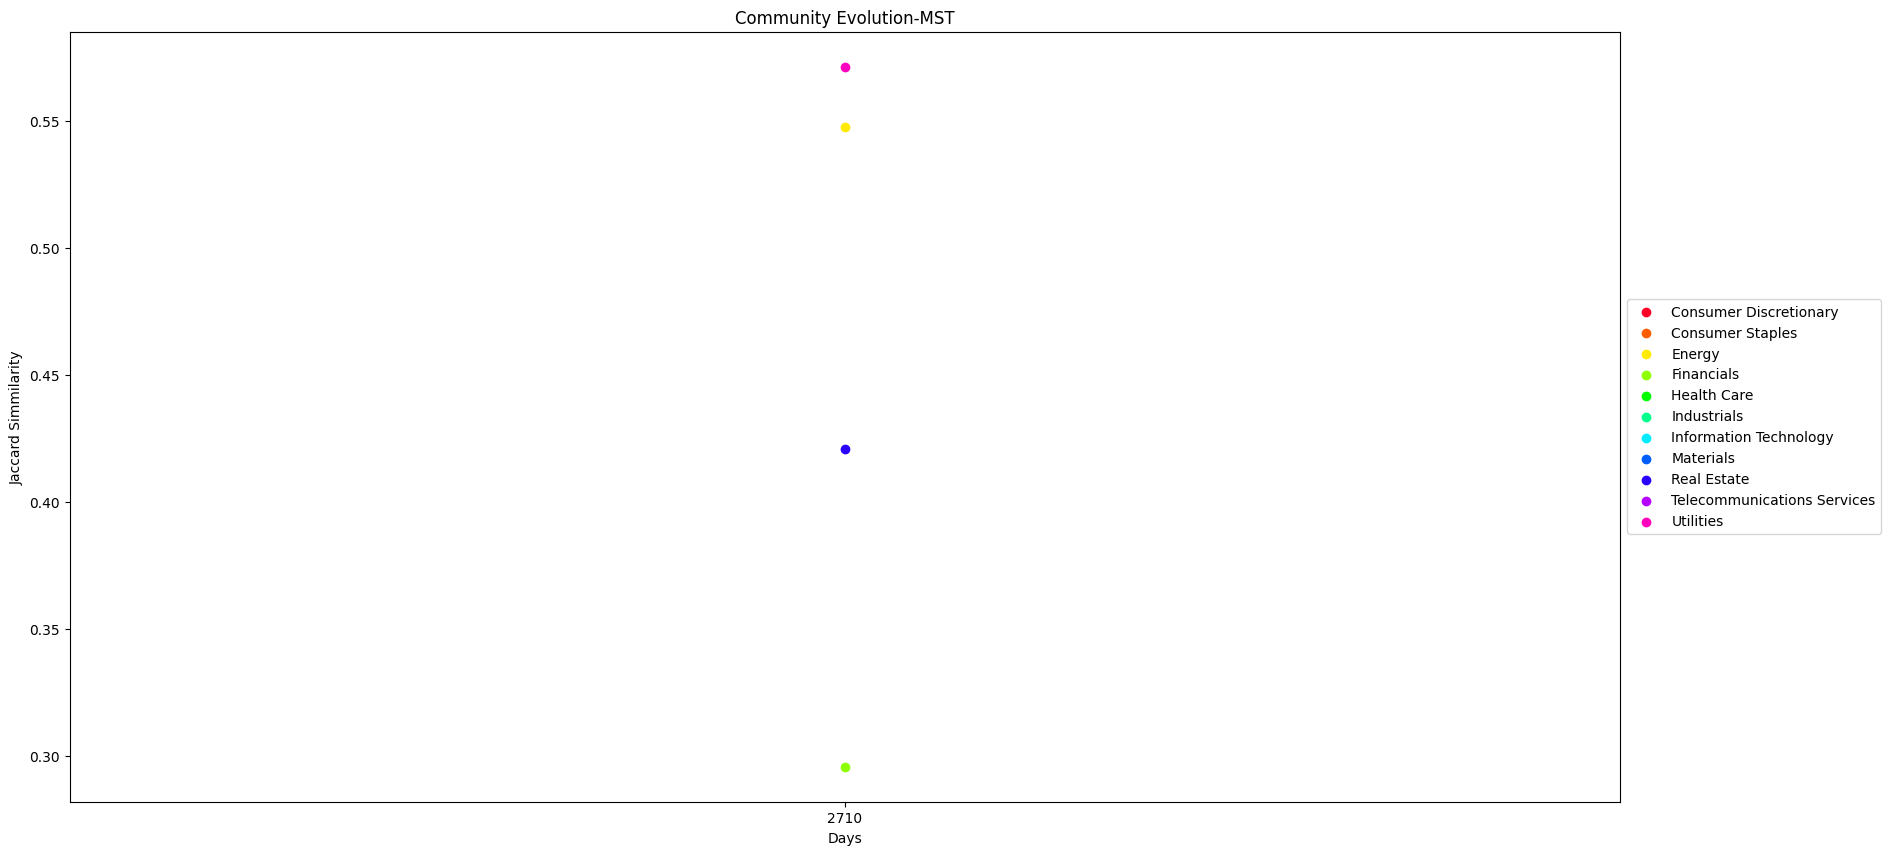

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,10))
cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = 11
colors = [cm(i) for i in np.linspace(0,1,NUM_COLORS)]
color_dict=dict(zip(list(jval.keys()), colors))
for key in jval:
    x = jval[key][0]
    y = jval[key][1]
    plt.scatter(x,y,color=color_dict[key],label=key)
    
#plt.legend(list(jval.keys()), loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Days')
plt.ylabel('Jaccard Simmilarity')
plt.title('Community Evolution-MST')
plt.show()

## 5.7 Visuvalize the network and the evolution

We then merged the graphs from different windows into one graph assigned and exported the output to gexf format to visuvalise the dynamic evolution of the network.Since the networkx gexf export doesn't support dynamic attributes we uses XML parsing to convert the GEXF file to include the dynamic attributes and visuvalised the network and its dynamic evolution in Gephi

The video is available here

https://www.youtube.com/watch?v=KGpEs97YWJ4


In [72]:
# Constructing a graph
import networkx as nx
M=nx.MultiGraph()
for y in G_dict.keys():
    M.add_nodes_from(G_dict[y].nodes(data=True))
    M.add_edges_from(G_dict[y].edges(data=True))
nx.write_gexf(M,'../data/price-sp500.gexf')

In [75]:
import xml.etree.ElementTree as ET
tree = ET.parse('../data/price-sp500.gexf')
root = tree.getroot()
for element in root.iter("{http://www.gexf.net/1.1draft}node"):
    #print (element.attrib)
    noden = element.attrib['id']
    for child in element:
        for i in range(len(child)):
            child.remove(child[0])
        for y in G_dict.keys():
            T = G_dict[y]
            n = 0
            try:
                for att in T.node[noden]:
                    new = ET.Element("{http://www.gexf.net/1.1draft}attvalue")
                    new.set('for',str(n))
                    new.set('value',str(T.node[noden][att]))
                    new.set('start',str(y))
                    new.set('end',str(y+W-1))
                    child.append(new)
                    #print (T.node[noden][att])
                    n = n + 1
            except:
                continue
for element in root.iter("{http://www.gexf.net/1.1draft}edge"):
    #print (element.attrib)
    noden = element.attrib['id']
    for child in element:
        for i in range(len(child)):
            child[i].set('start',str(element.attrib['start']))
            child[i].set('end',str(element.attrib['end']))
tree.write('../data/price-sp500-o.gexf')

In [76]:
# Constructing a graph
import networkx as nx
M=nx.MultiGraph()
for y in GMST_dict.keys():
    M.add_nodes_from(GMST_dict[y].nodes(data=True))
    M.add_edges_from(GMST_dict[y].edges(data=True))
nx.write_gexf(M,'../data/price-MST-sp500.gexf')

In [78]:
import xml.etree.ElementTree as ET
tree = ET.parse('../data/price-MST-sp500.gexf')
root = tree.getroot()
for element in root.iter("{http://www.gexf.net/1.1draft}node"):
    #print (element.attrib)
    noden = element.attrib['id']
    for child in element:
        for i in range(len(child)):
            child.remove(child[0])
        for y in GMST_dict.keys():
            T = GMST_dict[y]
            n = 0
            try:
                for att in T.node[noden]:
                    new = ET.Element("{http://www.gexf.net/1.1draft}attvalue")
                    new.set('for',str(n))
                    new.set('value',str(T.node[noden][att]))
                    new.set('start',str(y))
                    new.set('end',str(y+W-1))
                    child.append(new)
                    #print (T.node[noden][att])
                    n = n + 1
            except:
                continue
for element in root.iter("{http://www.gexf.net/1.1draft}edge"):
    #print (element.attrib)
    noden = element.attrib['id']
    for child in element:
        for i in range(len(child)):
            child[i].set('start',str(element.attrib['start']))
            child[i].set('end',str(element.attrib['end']))
tree.write('../data/price-MST-sp500-o.gexf')

## Conclusion

In conclusion we have been able to find answers to our questions and find some interesting results on the dynamics of the Equities in the S and P 500 index through Network Analysis.

We have  been able to

    1. Build networks for the various phases of the stock market between 2007 and 2017 split based on time periods,  for the stocks in the S and P 500 based  on the Winner Take All and the Minimum Spanning tree Method
    2. Analyse the network and found that the network indeed exhibits scale free properties
    3. Detect communities in these networks and compare these communities with the communities of the stocks based on the SIC code using Jaccard Similarity.
    4. Study the evolution of these communities and noted the essential result that there are some sectors which essentially trade together as a group and some that don't.
    5. Leverage the properties of the network to find the important stocks and the sectors which reflect movement of other stocks in the network
    6. Identify stocks/sectors which based on their Betweeness cetrality are ideally placed to predict the movement of the prices in the market
    7. Visuvalize the dynamic evolution of network by building dynamic graphs  using Gephi
    
The Analysis and the results provide a interesting insight into the stock market and its dynamic nature.The results from this study and further research can be used in areas of Portfolio optimisation, Risk Mitigation etc.Further analysis can also be done by building networks between different asset classes such as currency , commodities  and studying their evolution and behavior over time.

## Appendix

## MST-Network -  Period Starting 1702

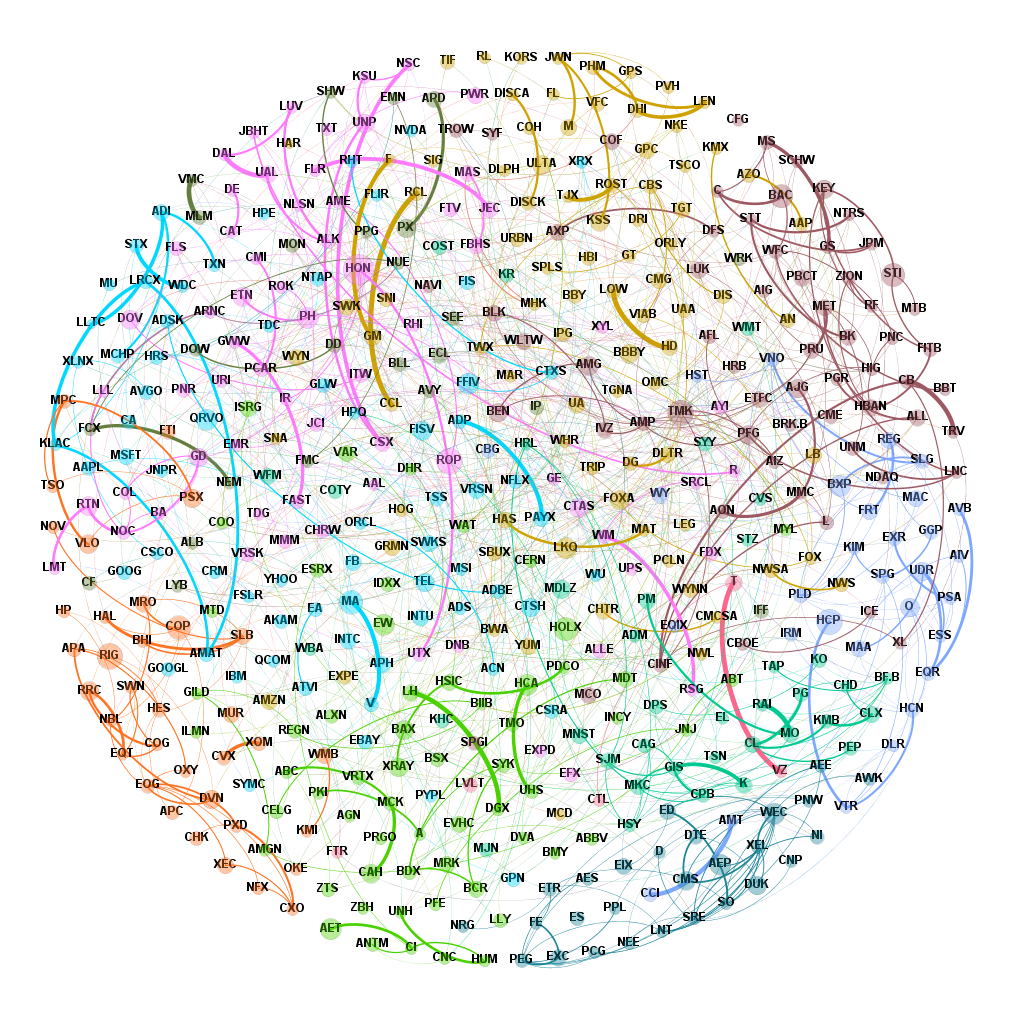

In [80]:
from IPython.display import Image
Image(filename='../data/MST-Period-1702.png') 

## Winner Take All -Network -  Period Starting 1702

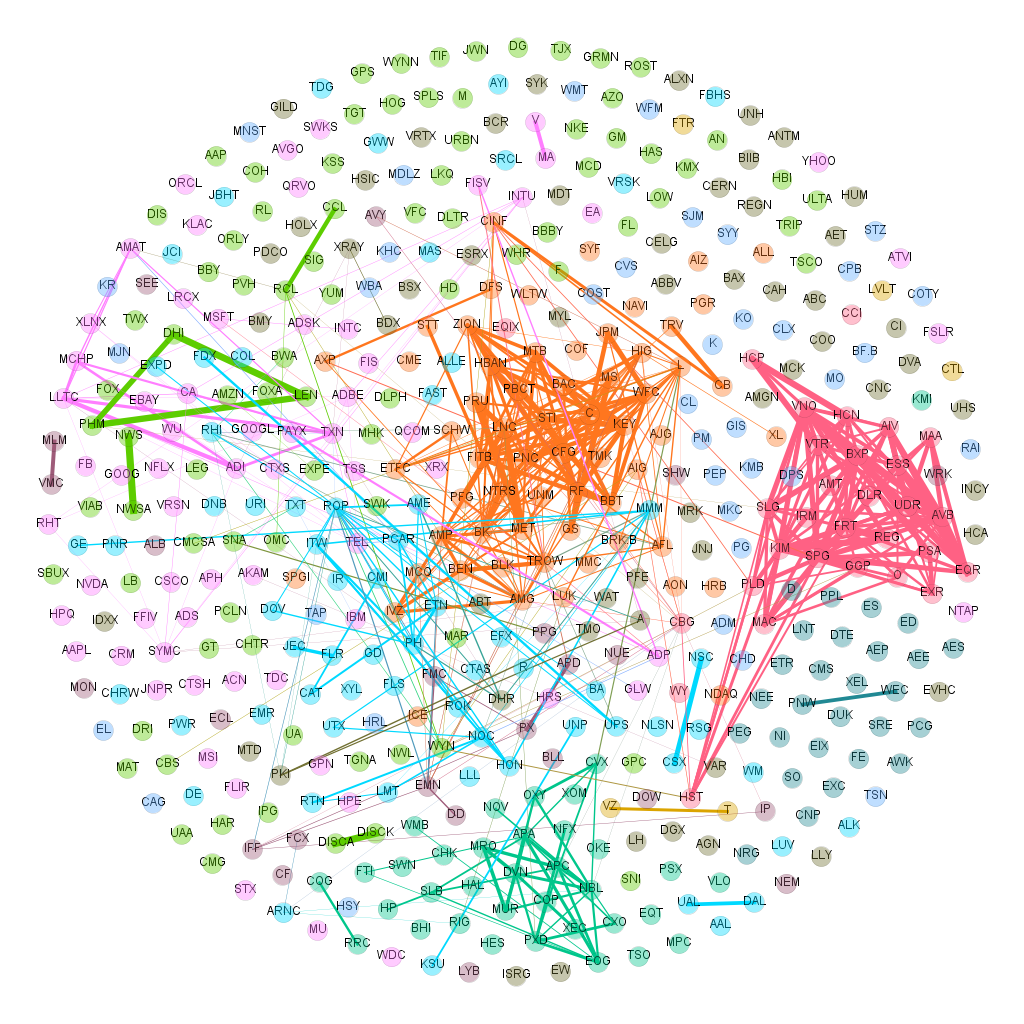

In [81]:
from IPython.display import Image
Image(filename='../data/WTA-period-1702.png') 

## Winner Take All -Network -  Period Starting 568

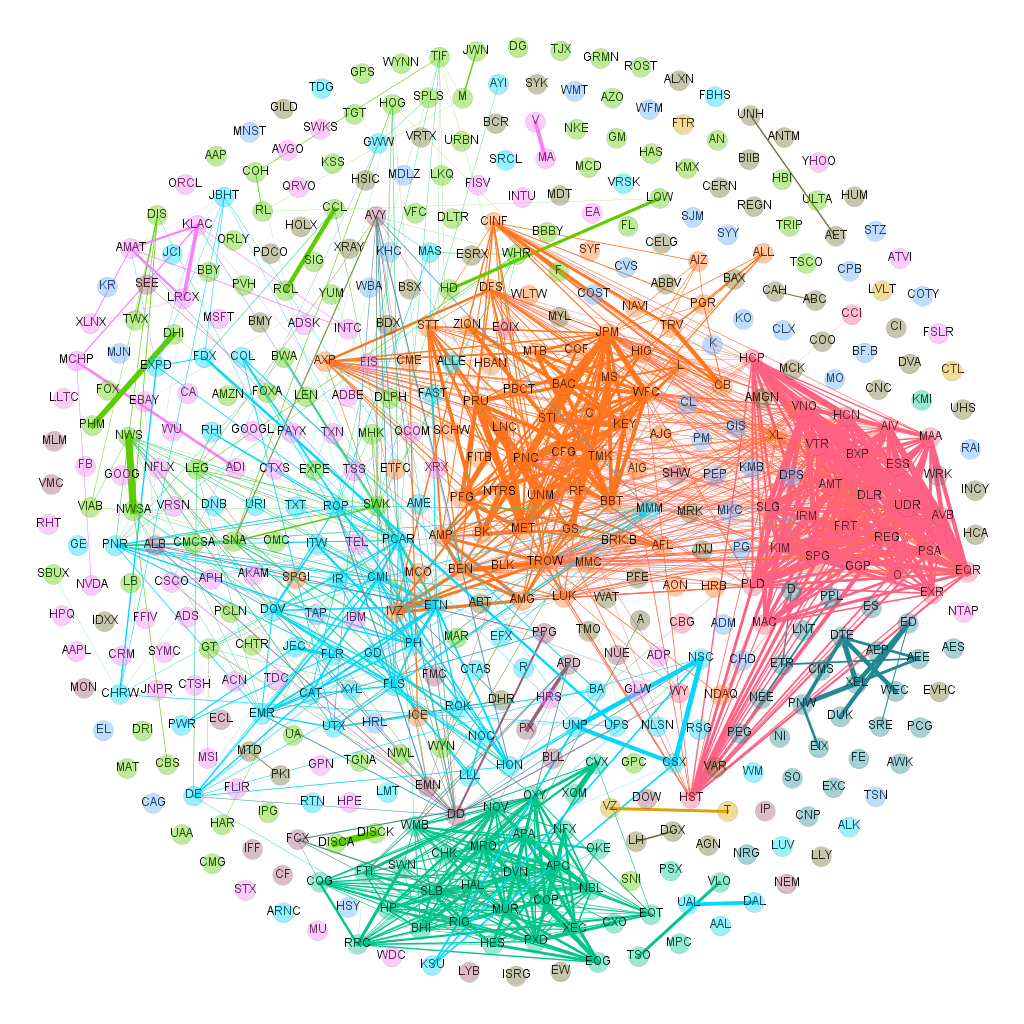

In [82]:
from IPython.display import Image
Image(filename='../data/WTA-period-568.png') 